# Carga de librerias necesarias

%pip install folium   
%pip install geopy   
%pip install geopandas   
%pip install dash-bootstrap-components   
%pip install dash   
%pip install tabulate

In [5]:
import mysql.connector
import pandas as pd
import numpy as np
from datetime import datetime
from mysql.connector import errorcode
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker # per poder utilitzar FuncFormatter i aplicar format a la barra
from matplotlib.ticker import FuncFormatter # per poder utilitzar el separador de milersimport geopandas as gpd
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point
import time
from geopy.exc import GeocoderTimedOut
import folium
from folium.plugins import MarkerCluster
import os
from dotenv import load_dotenv # type: ignore # per dades accedir base dades
from tabulate import tabulate # para formato de una tabla
from scipy.stats import skew

# Carregar credencials base de dades: arxiu .env

In [6]:
load_dotenv()

DB_HOST = os.getenv('host')
DB_USER = os.getenv('usuario')
DB_PASSWORD = os.getenv('clave')
DB_DATABASE = os.getenv('db')

# Conexion a MySQL para extraer tabla

In [ ]:
try:
    # Intentar conectar a la base de datos
    cnx = mysql.connector.connect(
        host=DB_HOST,
        user=DB_USER,
        password=DB_PASSWORD,
        database=DB_DATABASE,
        charset='utf8mb4'
    )
    mycursor = cnx.cursor()  # Crear cursor
    mycursor.execute("SHOW TABLES")   # Extraer nombre de la tabla
    MySQL_tablas = [tabla[0] for tabla in mycursor.fetchall()]

    # Ejecutar consulta para obtener los datos
    dataframes = {}
    mycursor = cnx.cursor(dictionary=True)  # Crear cursor habilitando diccionario
    for tabla in MySQL_tablas:
        mycursor.execute(f"SELECT * FROM {tabla}")
        dataframes[f"{tabla}"] = pd.DataFrame(mycursor.fetchall())

    # Imprimir los primeros registros
    print(dataframes.keys())
    locals().update(dataframes)

except mysql.connector.Error as err:
    # Manejo de errores específicos
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Usuario o contraseña incorrectos")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("La base de datos especificada no existe")
    else:
        print(f"Error inesperado: {err}")

finally:
    # Cerrar conexión
    try:
        if 'mycursor' in locals() and mycursor:
            mycursor.close()
        if 'cnx' in locals() and cnx.is_connected():
            cnx.close()
    except Exception as e:
        print(f"Error al cerrar la conexión: {e}")

dict_keys(['Tourist_Accommodation', 'Tourist_Accommodation22042025'])


# Limpieza

## Comprobar dataset

In [8]:
df = Tourist_Accommodation22042025
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   apartment_id                 8000 non-null   int64  
 1   name                         7997 non-null   object 
 2   description                  7946 non-null   object 
 3   host_id                      8000 non-null   int64  
 4   neighbourhood_name           8000 non-null   object 
 5   neighbourhood_district       4861 non-null   object 
 6   room_type                    8000 non-null   object 
 7   accommodates                 8000 non-null   int64  
 8   bathrooms                    7957 non-null   object 
 9   bedrooms                     7961 non-null   object 
 10  beds                         7992 non-null   float64
 11  amenities_list               7983 non-null   object 
 12  price                        7829 non-null   float64
 13  minimum_nights    

## Cambio de tipo de datos de fechas

In [9]:
df['first_review_date'] = pd.to_datetime(df['first_review_date'], format='%d/%m/%Y')
df['insert_date'] = pd.to_datetime(df['insert_date'], format='%d/%m/%Y')
df['last_review_date'] = pd.to_datetime(df['last_review_date'], format='%d/%m/%Y')

## Duplicados

### Funcion de duplicados

In [10]:
def mantener_fecha_mas_reciente(df, columna_id, columna_fecha):
    """
    Elimina duplicados basados en un ID, manteniendo la fila con la fecha más reciente.
    
    Parámetros:
    df (DataFrame): El DataFrame que contiene los datos.
    columna_id (str): El nombre de la columna que identifica los duplicados.
    columna_fecha (str): El nombre de la columna que contiene las fechas.

    Retorna:
    DataFrame: Un nuevo DataFrame con los IDs únicos y sus fechas más recientes.
    """

    # Ordenar por fecha descendente
    df = df.sort_values(by=columna_fecha, ascending=False)

    # Eliminar duplicados manteniendo el más reciente
    df = df.drop_duplicates(subset=columna_id, keep='last')

    return df



#### Numero de registros duplicados

In [11]:
total_registros = len(df)
valores_unicos = df['apartment_id'].nunique()
duplicados = total_registros - valores_unicos
print(f"Registros duplicados: {duplicados}")
print(f"Registros que deberían quedar: {valores_unicos}")

Registros duplicados: 307
Registros que deberían quedar: 7693


### Ejecutar funcion al dataset con el ID del apartamento y la fecha de insersion 

In [12]:
df = mantener_fecha_mas_reciente(df, columna_id='apartment_id', columna_fecha='insert_date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7693 entries, 3656 to 3006
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 7693 non-null   int64         
 1   name                         7690 non-null   object        
 2   description                  7641 non-null   object        
 3   host_id                      7693 non-null   int64         
 4   neighbourhood_name           7693 non-null   object        
 5   neighbourhood_district       4669 non-null   object        
 6   room_type                    7693 non-null   object        
 7   accommodates                 7693 non-null   int64         
 8   bathrooms                    7656 non-null   object        
 9   bedrooms                     7657 non-null   object        
 10  beds                         7685 non-null   float64       
 11  amenities_list               7676 non-null   

## Normalizacion de "Amenities"

#### Diccionario de equivalencias 

In [13]:
equivalencias = {
    # Categoría: Conectividad
    "wifi": ["wifi", "wi-fi", "wireless connection", "wireless internet", "wifi – 100 mbps", "pocket wifi"],
    
    # Categoría: Entretenimiento
    "tv": ["tv", "television", "cable tv", "smart tv", "netflix", "43 hdtv with netflix", "dvd player"],
    
    # Categoría: Climatización
    "air conditioning": ["air conditioning", "ac", "central air conditioning", "ceiling fan"],
    "heating": ["heating", "central heating"],

    # Categoría: Cocina
    "nespresso machine": ["nespresso machine", "espresso machine", "coffee maker", "pour-over coffee", "pour over coffee"],
    "oven": ["oven", "convection oven", "stainless steel oven", "double oven"],
    "stove": ["stove", "electric stove", "gas oven", "stainless steel stove"],
    "toaster": ["toaster", "bread maker"],
    "baking sheet": ["baking sheet"],
    "dishwasher": ["dishwasher"],
    "kitchen": ["kitchen", "full kitchen", "chef's kitchen", "kitchenette", "cooking basics"],
    "microwave": ["microwave", "microwave oven"],

    # Categoría: Habitaciones y camas
    "bed linens": ["bed linens", "extra pillows and blankets", "memory foam mattress", "pillow-top mattress", "firm mattress"],
    "crib": ["crib", "pack u2019n play/travel crib", "pack 'n play/travel crib"],

    # Categoría: Baños
    "bathtub": ["bathtub", "soaking tub", "hot tub"],
    "shower": ["roll-in shower", "rain shower", "shower chair", "step-free shower", "handheld shower head"],
    "bathroom essentials": ["toilet paper", "conditioner", "shampoo", "body soap", "bathroom essentials"],
    "hot water": ["hot water", "hot water kettle"],

    # Categoría: Accesibilidad
    "wheelchair accessible": ["wheelchair accessible", "flat path to guest entrance", "no stairs or steps to enter", "step-free access"],
    "wide clearance": ["wide clearance to shower & toilet", "wide clearance to bed", "wide doorway", "wide hallways"],
    "accessible-height bed": ["accessible-height bed", "accessible-height toilet"],

    # Categoría: Exterior
    "balcony": ["balcony", "patio or balcony"],
    "garden or backyard": ["garden or backyard", "shared garden or backyard"],
    "outdoor seating": ["outdoor seating", "terrace", "bbq grill"],
    "beachfront": ["beachfront", "beach essentials", "waterfront"],

    # Categoría: Niños y familia
    "children's amenities": ["children s books and toys", "children s dinnerware", "baby bath", "changing table", "stair gates", "table corner guards"],
    "high chair": ["high chair"],

    # Categoría: Seguridad
    "fire safety": ["fire extinguisher", "smoke alarm", "carbon monoxide alarm", "carbon monoxide detector", "fireplace guards"],
    "security system": ["security system"],

    # Categoría: Gimnasio y lujo
    "gym": ["gym", "exercise equipment"],
    "bluetooth sound system": ["bluetooth sound system", "sound system"],
    "heated towel rack": ["heated towel rack"],
    "wine glasses": ["wine glasses"],

    # Categoría: Estacionamiento
    "free parking": ["free parking on premises", "free parking on street", "free street parking"],
    "paid parking": ["paid parking on premises", "paid parking off premises", "paid parking garage"],

    # Categoría: Otros
    "iron": ["iron", "ironing board"],
    "workspace": ["dedicated workspace", "laptop-friendly workspace", "office", "printer"],
    "lockbox": ["lockbox"],
    "hangers": ["hangers"]
}
# Se puede actualizar el diccionario, segun se ingresen mas caracteristicas 



#### Funcion que normaliza las amenities


In [14]:
def normalizar_amenities(amenities, equivalencias):
    if not amenities:  # Si 'amenities' es None o está vacío
        return ''  # Retornamos un string vacío
    normalized = set()  # Usamos un conjunto para evitar duplicados
    for amenity in amenities.split(','):  # Dividimos por comas las amenidades
        matched = False
        for key, synonyms in equivalencias.items():
            for synonym in synonyms:
                if synonym.lower() in amenity.lower().strip():
                    normalized.add(key)
                    matched = True
                    break
        if not matched:  # Si no coincide con ninguna clave del diccionario
            normalized.add(amenity.lower().strip())  # Agregamos la amenidad como está
    return ', '.join(normalized)  # Retornamos las amenidades normalizadas

#### Normalizamos las amenities y creamos una nueva columna con las amenities normalizadas 

In [15]:
# Aplicamos la función a la columna 'amenities'
df['normalized_amenities'] = df['amenities_list'].apply(lambda x: normalizar_amenities(x, equivalencias))

# Mostramos el resultado
df[['normalized_amenities', 'amenities_list']].head()

,normalized_amenities,amenities_list
3656,"host greets you, long term stays allowed, elev...","Host greets you, Extra pillows and blankets, W..."
5770,"refrigerator, hot water, nespresso machine, di...","Pack u2019n Play/travel crib, Patio or balcony..."
7894,"balcony, refrigerator, microwave, nespresso ma...","Refrigerator, Long term stays allowed, Washer,..."
6749,"refrigerator, essentials, first aid kit, freez...","Host greets you, Cooking basics, Garden or bac..."
4507,"refrigerator, stove, long term stays allowed],...","Cooking basics, Garden or backyard, Bathtub, H..."


#### Mostrar la diferencia entre amenities unicas con y sin normalizar

In [16]:
# Extraer las amenidades originales únicas
amenidades_originales = set()
df['amenities_list'].dropna().apply(lambda x: [amenidades_originales.add(i.strip().lower()) for i in x.split(',')])

# Extraer las amenidades normalizadas únicas
amenidades_normalizadas = set()
df['normalized_amenities'].dropna().apply(lambda x: [amenidades_normalizadas.add(i.strip().lower()) for i in x.split(',')])

# Mostrar las amenidades únicas
print("Amenidades originales únicas:", len(amenidades_originales))
print("Amenidades normalizadas únicas:", len(amenidades_normalizadas))

Amenidades originales únicas: 317
Amenidades normalizadas únicas: 182


## Imputamos valor a los precios nulos

#### Exploración de los precios.

In [17]:
df[['apartment_id','price']].describe()

,apartment_id,price
count,7.693000e+03,7535.000000
mean,1.697283e+07,1006.227472
std,8.745042e+06,844.034751
min,1.196400e+04,60.000000
25%,1.075765e+07,450.000000
50%,1.808626e+07,750.000000
75%,2.363590e+07,1220.000000
max,3.242329e+07,6071.000000


Tenemos los precios de 6613 de los 6733 apartementos regristrados, con lo que 120 registros no tienen precio. O bien, lo que vendría siendo el 1.78% de los registros.

In [18]:
skewness = skew(df['price'].dropna())
print(f"La asimetría es de: {skewness:.2f}")

La asimetría es de: 2.08


Comprobamos el sesgo positivo en la distribución, donde vemos que la asimetría es positiva con una larga cola a la derecha, por lo que podemos intuir que posee muchos valores bajos y pocos muy altos.

Para corroborar esto vamos a graficar.

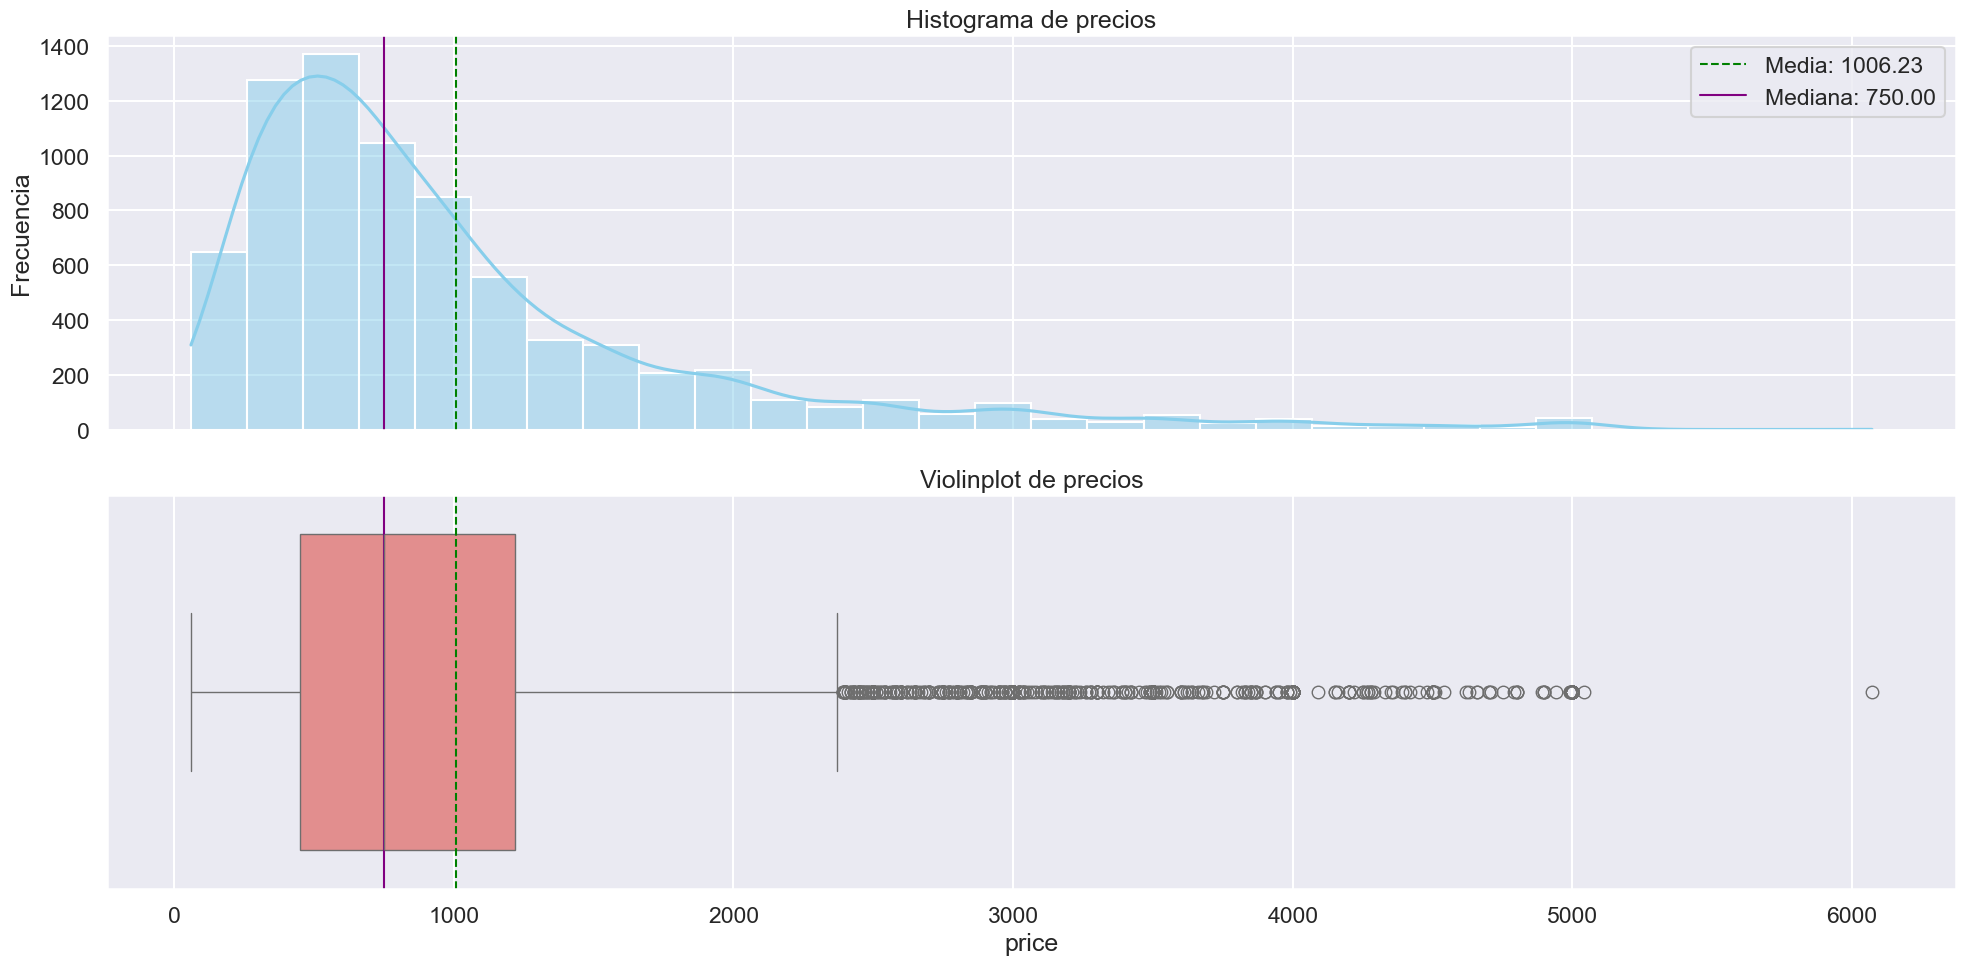

In [19]:
media_precio = df['price'].mean()
mediana_precio = df['price'].median()

sns.set_theme(context='talk', style='darkgrid')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)

sns.histplot(df['price'].dropna(), bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(media_precio, color='green', linestyle='--', linewidth=1.5, label=f'Media: {media_precio:.2f}')
axes[0].axvline(mediana_precio, color='purple', linestyle='-', linewidth=1.5, label=f'Mediana: {mediana_precio:.2f}')
axes[0].set_title('Histograma de precios')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

sns.boxplot(x=df['price'].dropna(), ax=axes[1], color='lightcoral')
axes[1].axvline(media_precio, color='green', linestyle='--', linewidth=1.5)
axes[1].axvline(mediana_precio, color='purple', linestyle='-', linewidth=1.5)
axes[1].set_title('Violinplot de precios')

plt.tight_layout()
plt.show()

Insights:
* Vemos que la distribución es asimétrica, con una cola larga de outliers a la derecha y con la mayoría de los precios hacia la izquierda. 
* Los outliers son de precios altos, más allá de 3.000 € y hasta 6.000 €.
* La mediana (750 €) está por debajo de la media (1009,92 €), lo cual confirma el sesgo positivo.

### Imputación
En este contexto, imputar por la media no sería lo ideal porque se vería muy influenciada por outliers.   
Por lo que optamos por imputar usando la mediana por ciudad, tipo de habitación y accomodates. Esto es simple pero efectivo.

In [20]:
df['price'] = df.groupby(['city', 'room_type', 'accommodates'])['price'].transform(
    lambda x: x.fillna(x.median()))

In [21]:
print(f'Hay {df["price"].isnull().sum()} precios con valores nulos')

Hay 8 precios con valores nulos


##### Filtramos los registros que siguen teniendo precios con valores nulos, y veremos que combinaciones no se pudieron imputar.

In [22]:
faltantes = df[df['price'].isnull()]

print(faltantes[['city', 'room_type', 'accommodates']].drop_duplicates())

           city        room_type  accommodates
4758   valencia     Private room             5
7181  barcelona       Hotel room             3
5459   mallorca  Entire home/apt            18
6756     madrid       Hotel room             4
4588    menorca  Entire home/apt            16
3247   mallorca  Entire home/apt            29
6234   mallorca  Entire home/apt            20
7675   mallorca  Entire home/apt            24


In [23]:
df['price'] = df.groupby(['city', 'room_type'])['price'].transform(
    lambda x: x.fillna(x.median()))

La primera ejecucion del código resulto en grupos que seguían teniedo valores nulos en 6 registros, por eso agregamos una segunda parte con un grupo más general para estos casos (sin tomar en cuenta los 'accommodates', solo ciudad y tipo de habitacion).

##### Segunda comprobación

In [24]:
print(f"Hay {df['price'].isnull().sum()} precios con valores nulos")

Hay 0 precios con valores nulos


# EDA's 

### EDA Operaciones

#### Funciones 

Función de generación de gráficos EDA Operaciones

In [25]:
def generar_graficos_disponibilidad(df):
    
    # Calcular la media de disponibilidad por ciudad
    disponibilidad_media = df.groupby('city')[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean()

    # Calcular el porcentaje de disponibilidad respecto al total de días posibles (30, 60, 90, 365)
    disponibilidad_media_porcentaje = disponibilidad_media.copy()

    # Calcular el porcentaje para cada columna de disponibilidad
    disponibilidad_media_porcentaje['availability_30'] = (disponibilidad_media['availability_30'] / 30) * 100
    disponibilidad_media_porcentaje['availability_60'] = (disponibilidad_media['availability_60'] / 60) * 100
    disponibilidad_media_porcentaje['availability_90'] = (disponibilidad_media['availability_90'] / 90) * 100
    disponibilidad_media_porcentaje['availability_365'] = (disponibilidad_media['availability_365'] / 365) * 100

    # Definir una paleta de colores coherente y con buen contraste para los gráficos
    colores = sns.color_palette("Set2", 4)  # Usamos una paleta de colores más saturados y contrastantes

    # Mostrar la media de disponibilidad por ciudad
    print("Media de disponibilidad por ciudad\n")
    print(disponibilidad_media)

    # Mostrar la media de disponibilidad en porcentaje por ciudad
    print("\nMedia de disponibilidad en porcentaje por ciudad\n")
    print(disponibilidad_media_porcentaje)

Funcion de distribución de la disponibilidad en los distintos períodos boxplot

In [26]:
def distribucion_disponibilidadboxplot(df, colores):
    # Crear la figura y la cuadrícula de subgráficos (2x2)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas
    
    # Lista de períodos de disponibilidad
    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]
    
    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)
        
        # Seleccionar el eje correspondiente en la cuadrícula
        sns.boxplot(data=disponibilidad, color=colores[i], ax=ax[fila, columna])
        
        # Añadir título y etiquetas
        ax[fila, columna].set_title(f'Distribución de la Disponibilidad en los Últimos {periodo} Días', fontsize=12)
        ax[fila, columna].set_xlabel(f'Días Disponibles (Últimos {periodo} días)', fontsize=10)
        ax[fila, columna].set_ylabel('Días Disponibles', fontsize=10)
    
    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion de  distribución de la disponibilidad en los distintos períodos barras

In [27]:
def distribucion_disponibilidadbarras(df, colores):
    # Crear la figura y la cuadrícula de subgráficos (2x2)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas
    
    # Lista de períodos de disponibilidad
    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]
    
    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)
        
        # Seleccionar el eje correspondiente en la cuadrícula
        sns.histplot(disponibilidad, kde=True, color=colores[i], bins=30, ax=ax[fila, columna])
        
        # Añadir título y etiquetas
        ax[fila, columna].set_title(f'Distribución de la Disponibilidad en los Últimos {periodo} Días', fontsize=12)
        ax[fila, columna].set_xlabel(f'Días Disponibles (Últimos {periodo} días)', fontsize=10)
        ax[fila, columna].set_ylabel('Frecuencia', fontsize=10)
    
    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion de mini gráficos para cada categoría de disponibilidad

In [28]:
def mini_graficos_categoria(disponibilidad_media, colores):
    # Segunda parte: Mini gráficos para cada categoría de disponibilidad (sin porcentajes)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas

    # Lista de categorías
    categorias = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

    for i, categoria in enumerate(categorias):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)

        ax_sub = ax[fila, columna]
        # Para cada categoría, mostrar la disponibilidad media sin porcentajes
        disponibilidad_media[categoria].plot(kind='bar', ax=ax_sub, width=0.8, color=colores[i])

        ax_sub.set_title(f'Disponibilidad Media {categoria}', fontsize=12)
        ax_sub.set_xlabel('Ciudad', fontsize=10)
        ax_sub.set_ylabel(f'Media {categoria}', fontsize=10)
        ax_sub.set_xticklabels(disponibilidad_media.index, rotation=45, ha='right')

    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion para cada ciudad con disponibilidad media en porcentaje

In [29]:
def graficos_por_ciudad(disponibilidad_media_porcentaje, colores):
    # Tercera parte: Gráficos de barras para cada ciudad con la disponibilidad media en porcentaje
    
    # Determinar el número de filas y columnas en la cuadrícula (4x4)
    num_ciudades = len(disponibilidad_media_porcentaje)
    filas = 2
    columnas = 4
    
    # Crear la figura y la cuadrícula de subgráficos
    fig, ax = plt.subplots(filas, columnas, figsize=(20, 10))  # Ajustamos el tamaño de la figura
    
    # Convertir la matriz de ejes en una lista para poder iterar sobre ella
    ax = ax.flatten()
    
    for i, ciudad in enumerate(disponibilidad_media_porcentaje.index):
        # Extraer los valores de disponibilidad para la ciudad
        ciudad_data = disponibilidad_media_porcentaje.loc[ciudad]

        # Seleccionar el eje correspondiente en la cuadrícula
        ax[i].bar(ciudad_data.index, ciudad_data.values, color=colores, width=0.8)

        # Añadir título y etiquetas
        ax[i].set_title(f'Disponibilidad Media (%)\npor Ciudad: {ciudad}', fontsize=12)
        ax[i].set_xlabel('Periodo (días)', fontsize=10)
        ax[i].set_ylabel('Disponibilidad Media (%)', fontsize=10)

        # Ajustar las etiquetas del eje X automáticamente
        ax[i].tick_params(axis='x', rotation=45)

        # Establecer los límites de los ejes
        ax[i].set_ylim(0, 100)  # Limitar el eje Y de 0 a 100
        ax[i].set_xlim(-0.5, 3.5)  # Limitar el eje X de 0 a 3 (porque tenemos 4 barras)

    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion de las medias de todas las ciudades

In [30]:
def grafico_media_todas_las_ciudades(disponibilidad_media_porcentaje, colores):
    # Última parte: Gráfico de las medias de todas las ciudades
    plt.figure(figsize=(12, 8))
    disponibilidad_media_porcentaje.plot(kind='bar', figsize=(12, 8), color=colores)
    plt.title('Disponibilidad Media (%) de los Alojamientos Turísticos por Ciudad')
    plt.xlabel('Ciudad')
    plt.ylabel('Disponibilidad Media (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### Graficos

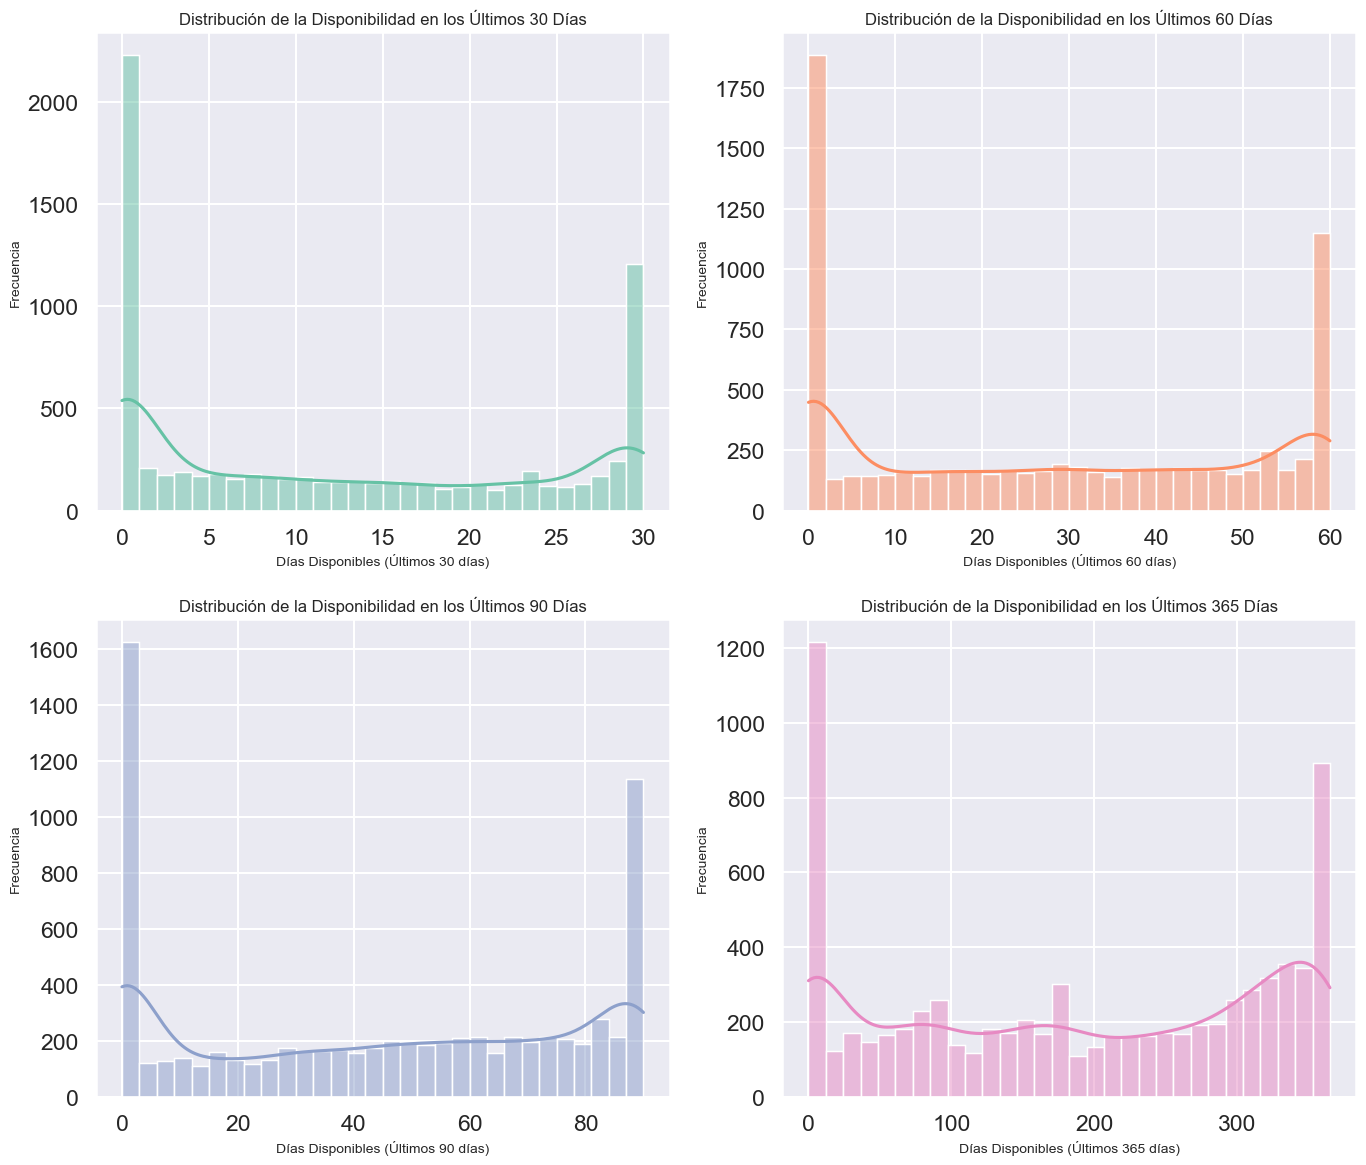

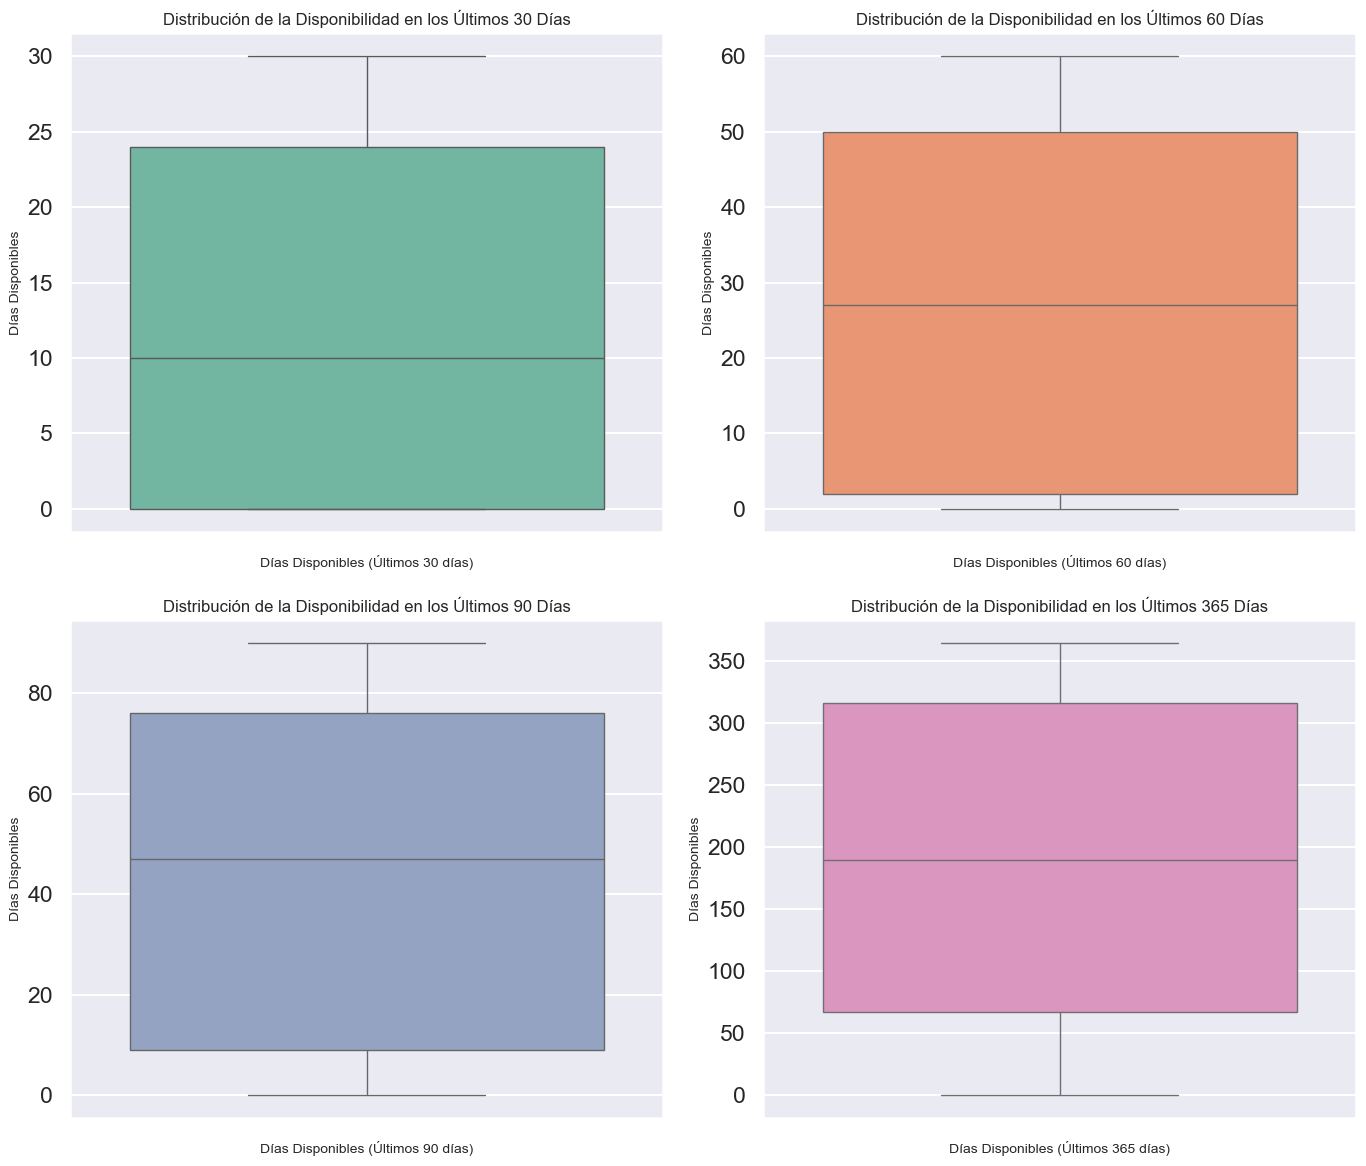

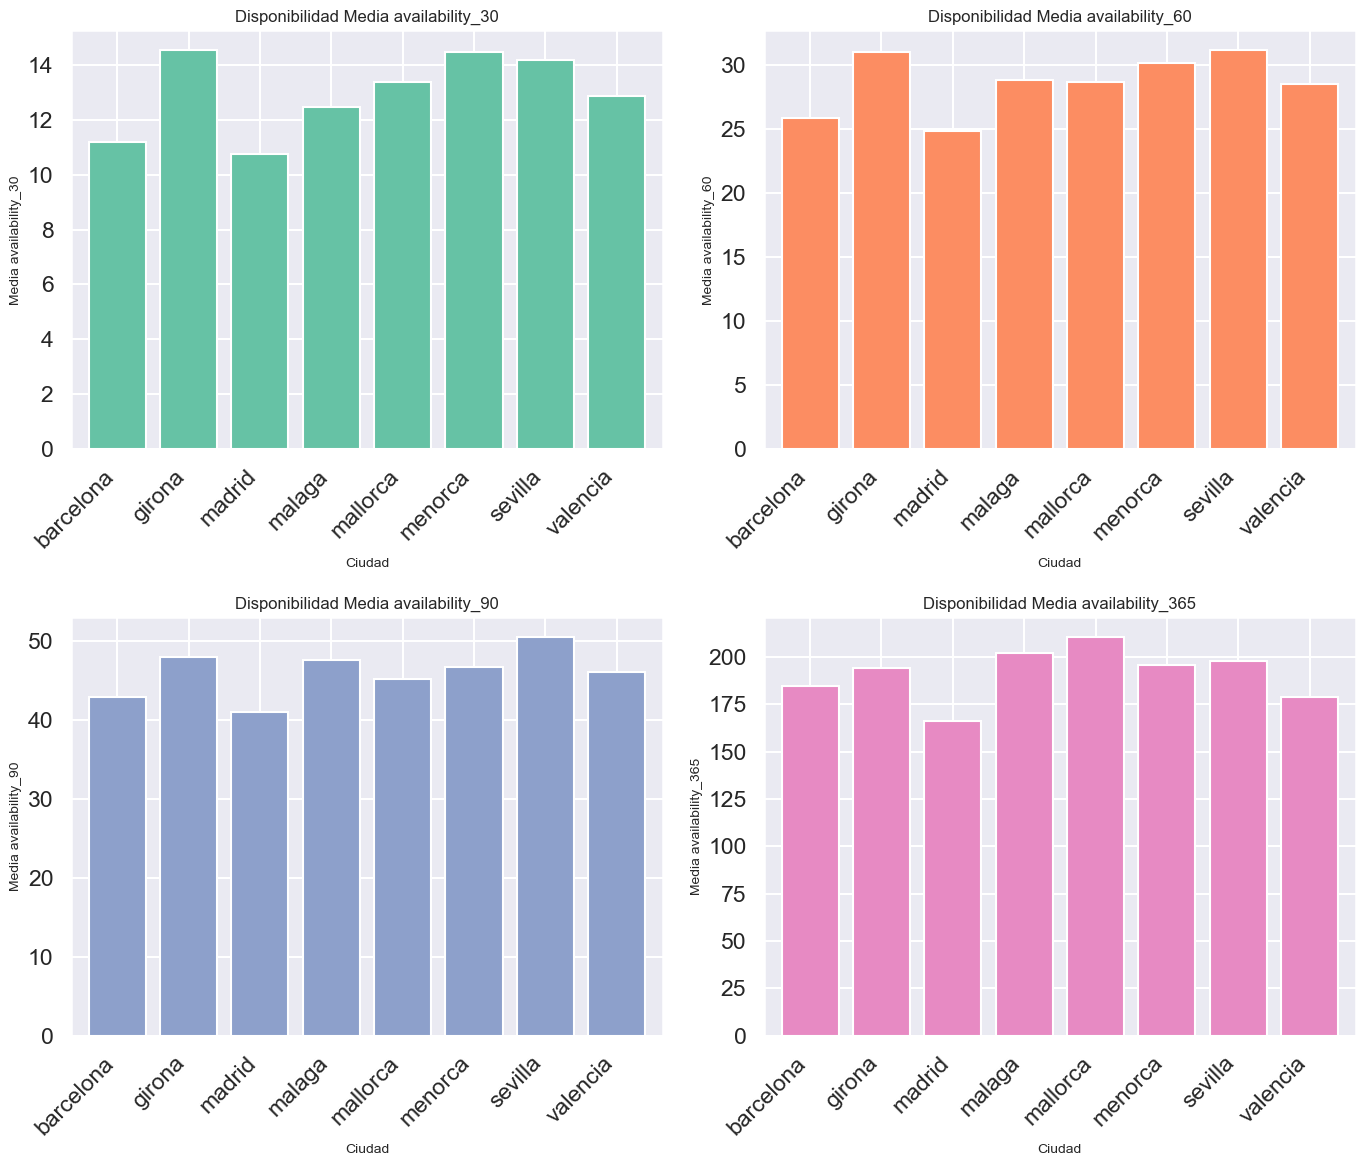

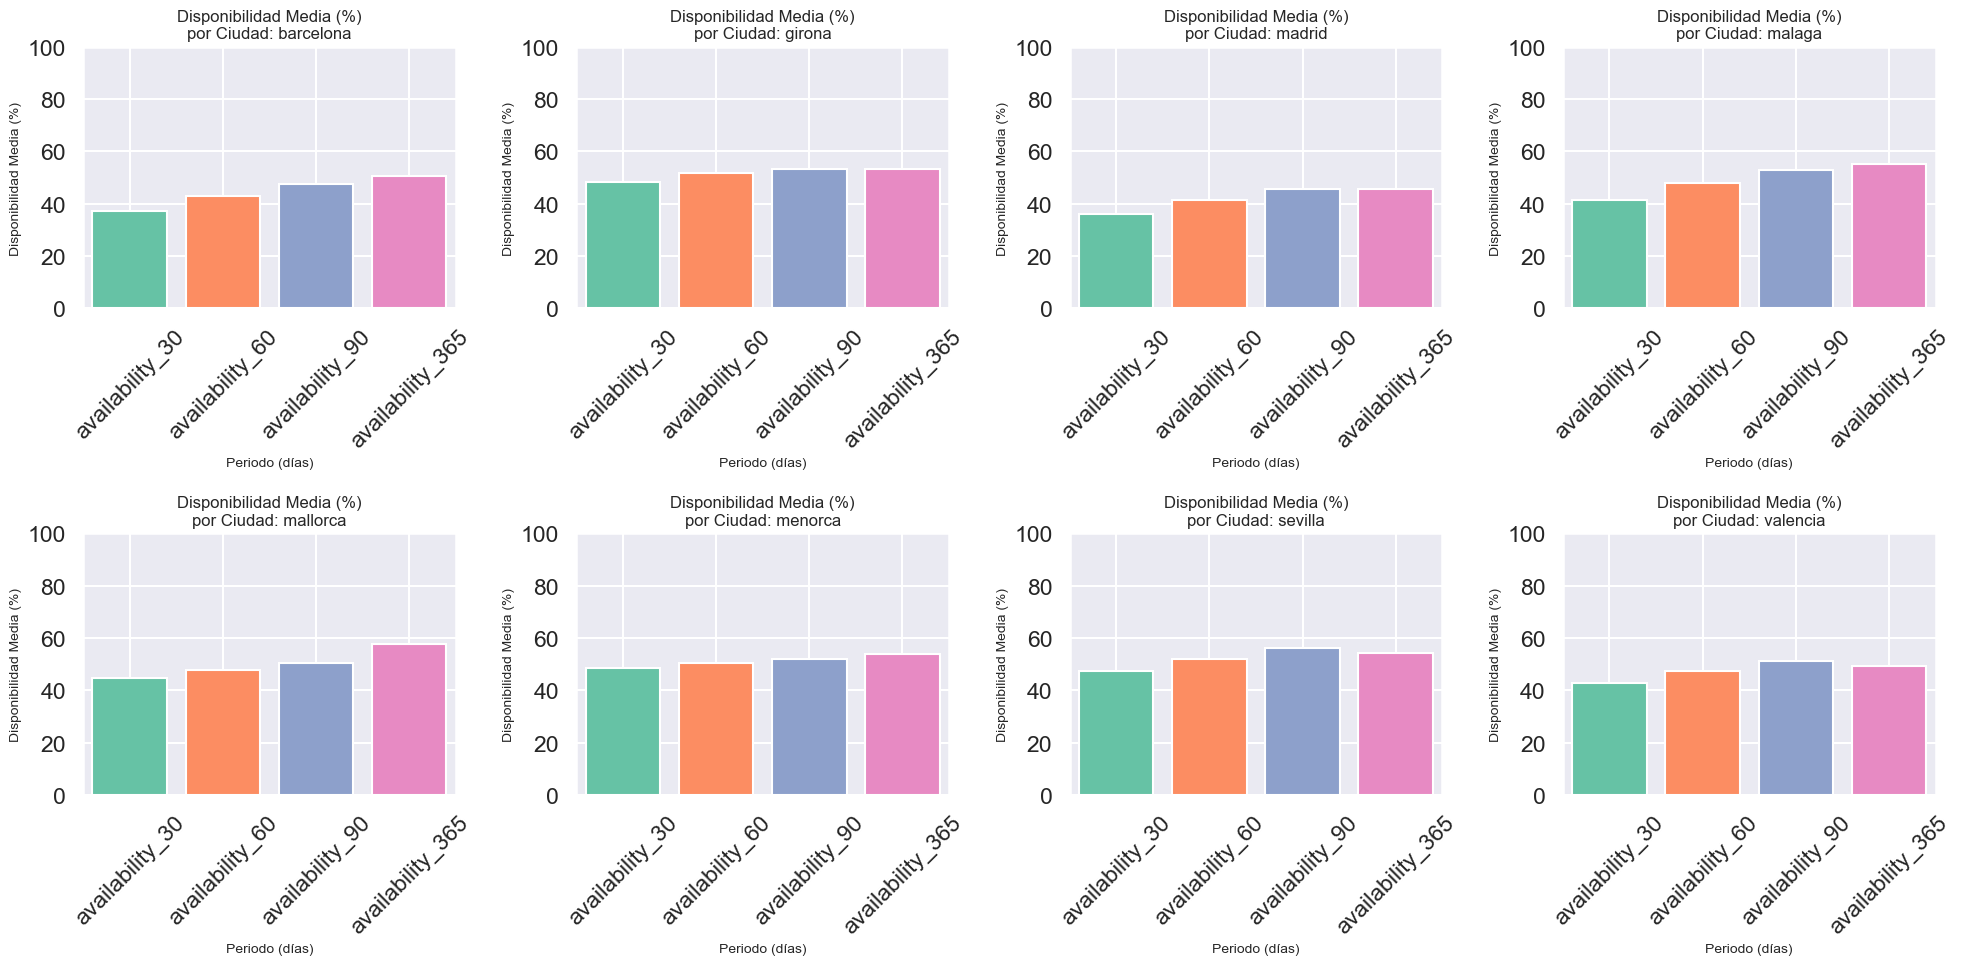

<Figure size 1200x800 with 0 Axes>

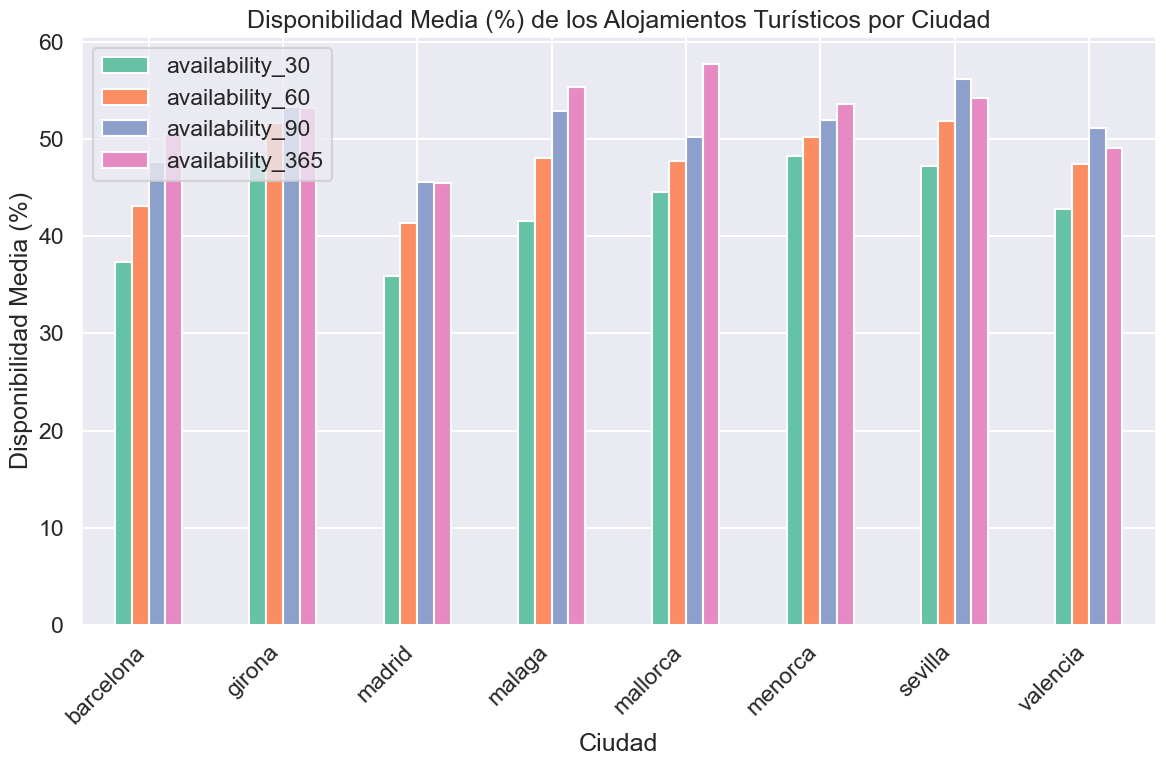

In [31]:
# Primero, calcular los porcentajes y la media
disponibilidad_media = df.groupby('city')[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean()
disponibilidad_media_porcentaje = disponibilidad_media.copy()

# Calcular los porcentajes para cada columna
disponibilidad_media_porcentaje['availability_30'] = (disponibilidad_media['availability_30'] / 30) * 100
disponibilidad_media_porcentaje['availability_60'] = (disponibilidad_media['availability_60'] / 60) * 100
disponibilidad_media_porcentaje['availability_90'] = (disponibilidad_media['availability_90'] / 90) * 100
disponibilidad_media_porcentaje['availability_365'] = (disponibilidad_media['availability_365'] / 365) * 100

# Definir la paleta de colores
colores = sns.color_palette("Set2", 4)

# Llamar las funciones para generar los gráficos
distribucion_disponibilidadbarras(df, colores)
distribucion_disponibilidadboxplot(df, colores)
mini_graficos_categoria(disponibilidad_media, colores)
graficos_por_ciudad(disponibilidad_media_porcentaje, colores)
grafico_media_todas_las_ciudades(disponibilidad_media_porcentaje, colores)

### EDA Clientes

#### Analisis descriptivo

In [32]:
df[['apartment_id', 'first_review_date', 'last_review_date',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month','city']].describe(include='all')

,apartment_id,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,city
count,7.693000e+03,6120,6119,6041.000000,6032.000000,6038.000000,6027.000000,6036.000000,6026.000000,6026.000000,6120.000000,7693
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,barcelona
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2261
mean,1.697283e+07,2017-02-03 13:15:31.764706048,2018-11-13 22:24:41.418532352,919.395795,94.537467,93.113614,96.256844,96.338635,95.270495,91.397278,125.181373,NaN
min,1.196400e+04,2010-01-02 00:00:00,2012-11-17 00:00:00,200.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,1.000000,NaN
25%,1.075765e+07,2016-03-29 00:00:00,2018-04-08 00:00:00,890.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,18.000000,NaN
50%,1.808626e+07,2017-05-26 00:00:00,2018-12-02 00:00:00,940.000000,100.000000,100.000000,100.000000,100.000000,100.000000,90.000000,58.000000,NaN
75%,2.363590e+07,2018-05-12 00:00:00,2019-09-12 00:00:00,980.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,179.500000,NaN
max,3.242329e+07,2020-10-24 00:00:00,2021-02-13 00:00:00,1000.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1291.000000,NaN


##### Cantidad de apartamentos sin reseñas

In [33]:
sin_reseñas = df['first_review_date'].isna().sum()
print(f"Número de apartamentos sin reseñas: {sin_reseñas}")

Número de apartamentos sin reseñas: 1573


##### Porcentaje de apartamentos del total


In [34]:
porcentaje_sin_reseñas = (sin_reseñas / len(df)) * 100
print(f"Porcentaje de apartamentos sin reseñas: {porcentaje_sin_reseñas:.2f} %")

Porcentaje de apartamentos sin reseñas: 20.45 %


In [35]:
top_apartamentos_puntos = df.sort_values(['review_scores_rating', 'number_of_reviews'], ascending=False)
top_apartamentos_puntos.head(10)

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,normalized_amenities
2218,11989301,Vivienda San Mart�n II,Rel�jate y desconecta mientras la c�lida luz v...,34840363,SANT FRANCESC,CIUTAT VELLA,Entire home/apt,4,1,1,...,100.0,100.0,100.0,100.0,VERDADERO,394.0,spain,valencia,2019-12-31,"wide clearance, refrigerator, first aid kit, b..."
1783,9122183,Casa sevillana en barrio historico,Habitaci�n luminosa con terraza privada para u...,47528412,Pio XII,Macarena,Private room,2,2,1,...,100.0,100.0,90.0,100.0,FALSO,347.0,spain,sevilla,2019-07-29,"wide clearance, refrigerator, luggage dropoff ..."
5759,22979863,"Stylish Apt PZA MAYOR/La Latina 2BD* 2BT*, 6p max","Cozy and well-designed 2 bedroom apartment, co...",29281033,Palacio,Centro,Entire home/apt,6,2,2,...,100.0,100.0,100.0,100.0,VERDADERO,376.0,spain,madrid,2021-01-12,"refrigerator, luggage dropoff allowed, stove, ..."
6072,23782265,Romantic and Rustic Penthouse with a Sun Kisse...,Marvel at an adorable cottage-like space in an...,40929334,ARRANCAPINS,EXTRAMURS,Entire home/apt,2,1,1,...,100.0,100.0,100.0,90.0,VERDADERO,501.0,spain,valencia,2020-05-31,"refrigerator, luggage dropoff allowed, bath to..."
5587,22479174,Private room in detached house,"Cozy private room in a detached villa, near Ad...",80975261,Rejas,San Blas - Canillejas,Private room,2,2,1,...,100.0,100.0,100.0,100.0,FALSO,327.0,spain,madrid,2020-08-25,"refrigerator, first aid kit, stove, hot water,..."
3365,16292600,BCN Luxury,Lujoso apartamento en pleno centro de Barcelon...,15944590,l'Antiga Esquerra de l'Eixample,Eixample,Entire home/apt,4,2,2,...,100.0,100.0,100.0,100.0,FALSO,274.0,spain,barcelona,2020-02-16,"refrigerator, internet, luggage dropoff allowe..."
309,1073748,"MAGIC PLACE IN BARCELONA, WITH POOL",<b>The space</b><br />MAGIC PLACE IN BARCELONA...,5159312,"Vallvidrera, el Tibidabo i les Planes",Sarri�-Sant Gervasi,Entire home/apt,4,1,1,...,100.0,100.0,100.0,100.0,VERDADERO,101.0,spain,barcelona,2020-11-06,"refrigerator, luggage dropoff allowed, stove, ..."
3717,17384311,"Cubic House Garden, Cala Morlanda.",Cozy designer apartment located in a nice gar...,11087082,Manacor,None,Entire home/apt,3,1,1,...,100.0,100.0,90.0,100.0,VERDADERO,196.0,spain,mallorca,2020-10-21,"shower gel, refrigerator, first aid kit, stove..."
5404,21916433,Typical majorcan house in Llucmajor,Cozy 2 floors family house with 5 double bedro...,159911693,Llucmajor,None,Entire home/apt,10,3,5,...,100.0,100.0,90.0,100.0,FALSO,314.0,spain,mallorca,2020-03-22,"refrigerator, luggage dropoff allowed, stove, ..."
5408,21925668,�tico con piscina Triana 2mm del Centro de sev...,Nous sommes � Triana � 2mm du centre de Sevill...,15589434,Triana Casco Antiguo,Triana,Entire home/apt,7,2,3,...,100.0,100.0,100.0,100.0,VERDADERO,514.0,spain,sevilla,2019-02-18,"wide clearance, refrigerator, luggage dropoff ..."


In [36]:
top_apartamentos_num_reviews = df.sort_values(['number_of_reviews', 'review_scores_rating'], ascending=False)
top_apartamentos_num_reviews.head(10)

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,normalized_amenities
63,384727,Private Room in Center of Seville,"located in the centre of Seville, offers accom...",1920069,Arenal,Casco Antiguo,Private room,2,1,1,...,100.0,100.0,100.0,100.0,FALSO,681.0,spain,sevilla,2019-06-29,"host greets you, first aid kit, heating, wifi,..."
264,959840,PL REAL (Sq) PENTHOUSE Rooftop,"Rustic penthous with old beams,old ceramic flo...",5223863,el Barri G�tic,Ciutat Vella,Private room,2,2,1,...,100.0,100.0,100.0,100.0,VERDADERO,71.0,spain,barcelona,2019-12-10,"wide clearance, refrigerator, internet, luggag..."
511,1871218,�tico apartamento VFT/SE/00804,"�tico muy luminoso. Consta de: Sal�n, Ba�o, Co...",9751847,"Le�n XIII, Los Naranjos",Macarena,Entire home/apt,2,1,1,...,100.0,100.0,90.0,80.0,VERDADERO,698.0,spain,sevilla,2020-01-30,"internet, first aid kit, stove, hot water, smo..."
729,3058631,"Private Studio in Sol, Madrid","We are offering a clean, well presented and re...",14370747,Sol,Centro,Entire home/apt,3,1,1,...,100.0,100.0,100.0,90.0,FALSO,698.0,spain,madrid,2020-07-17,"refrigerator, stove, hot water, oven, elevator..."
98,526513,Sol. Your home in Madrid�s Heart,DESIGN apartment in the HEART of Madrid.<br />...,1134989,Sol,Centro,Entire home/apt,5,1,2,...,100.0,100.0,100.0,100.0,VERDADERO,491.0,spain,madrid,2021-01-12,"shower gel, refrigerator, luggage dropoff allo..."
753,3143400,Great room in the center of Madrid,"Bright room in hortaleza Street, next to Gran ...",15328893,Justicia,Centro,Private room,2,1,1,...,100.0,100.0,100.0,100.0,VERDADERO,773.0,spain,madrid,2020-10-17,"refrigerator, stove, oven, nespresso machine, ..."
145,681925,"Very Central, Stunning Views, Sunny Terrace, W...",FANTASTIC PENTHOUSE LOCATED IN THE CENTER OF V...,3462415,EL PILAR,CIUTAT VELLA,Entire home/apt,2,1,1,...,100.0,100.0,100.0,100.0,VERDADERO,624.0,spain,valencia,2019-05-31,"refrigerator, first aid kit, stove, hot water,..."
478,1670427,Walk everywhere!Brand new apartWIFI,The apartment is right in the center of Barce...,8843962,la Dreta de l'Eixample,Eixample,Entire home/apt,5,1,1,...,100.0,100.0,100.0,90.0,VERDADERO,588.0,spain,barcelona,2020-10-12,"refrigerator, hot water, elevator, dishes and ..."
936,4028518,Renovated & Vintage en Barcelona,Welcome to this cozy apartment located in the ...,20886062,la Sagrada Fam�lia,Eixample,Entire home/apt,4,1,2,...,100.0,100.0,100.0,100.0,VERDADERO,712.0,spain,barcelona,2020-03-16,"refrigerator, ev charger, first aid kit, stove..."
1313,6289283,Cozy apartment near El Raval,Nice bright room with large private terrace (p...,32695481,el Raval,Ciutat Vella,Private room,2,1,1,...,100.0,90.0,90.0,90.0,VERDADERO,78.0,spain,barcelona,2020-03-16,"refrigerator, internet, stove, hot water, 24-h..."


#### Imputar fecha de inserción del registro para los casos en que hay reseñas y la last_review_date es nula


In [37]:
df.loc[df['last_review_date'].isna() & df['first_review_date'].notna(), 'last_review_date'] = df['insert_date']

#### Graficos

##### Distribución de números de reviews

Text(0.5, 0, 'N.º de reseñas')

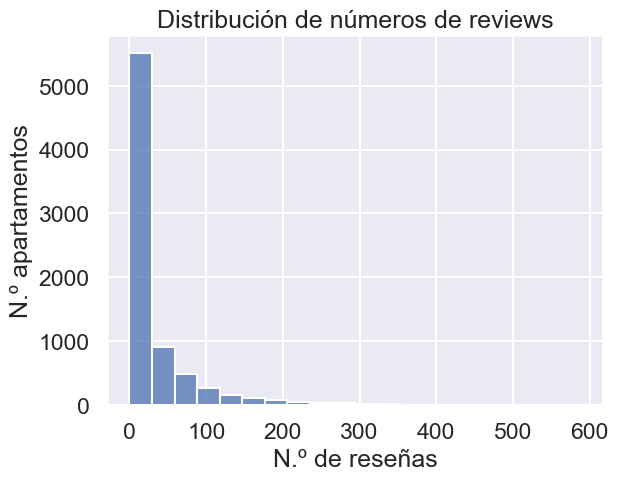

In [38]:
ax = sns.histplot(data=df, x='number_of_reviews', bins=20)
ax.set_title("Distribución de números de reviews")
ax.set_ylabel("N.º apartamentos")
ax.set_xlabel("N.º de reseñas")

##### Kde de distribución de reviews

Text(0.5, 0.98, 'Kde de distribución de reviews')

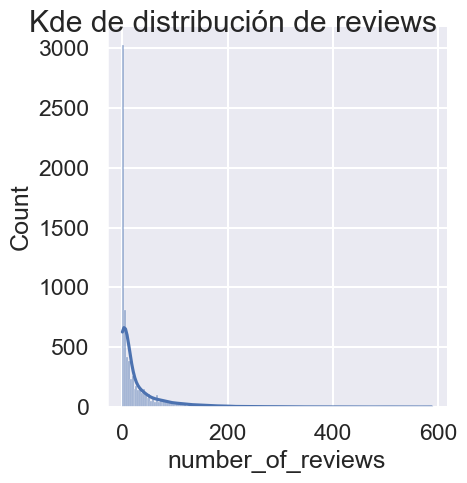

In [39]:
ax = sns.displot(data=df, x='number_of_reviews', kde=True)
ax.figure.suptitle("Kde de distribución de reviews")

##### Distribución estadística del rating total por ciudad

Text(0.5, 1.0, 'Distribución estadística del rating total por ciudad')

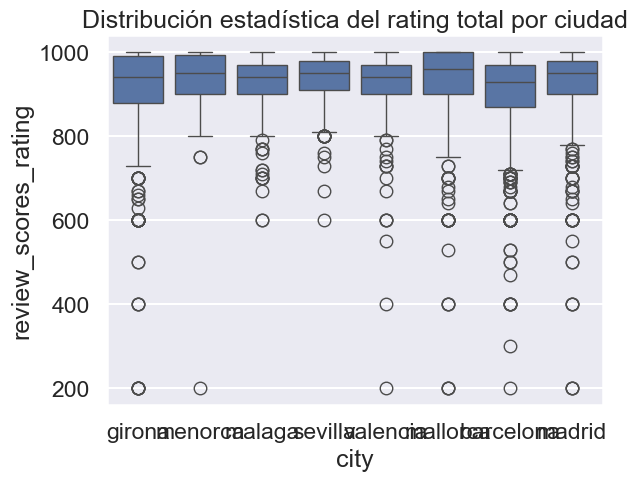

In [40]:
ax = sns.boxplot(data=df, x='city', y='review_scores_rating')
ax.set_title("Distribución estadística del rating total por ciudad")

##### Distribución estadística del rating total por tipo de alojamiento

Text(0.5, 1.0, 'Distribución estadística del rating total por tipo de alojamiento')

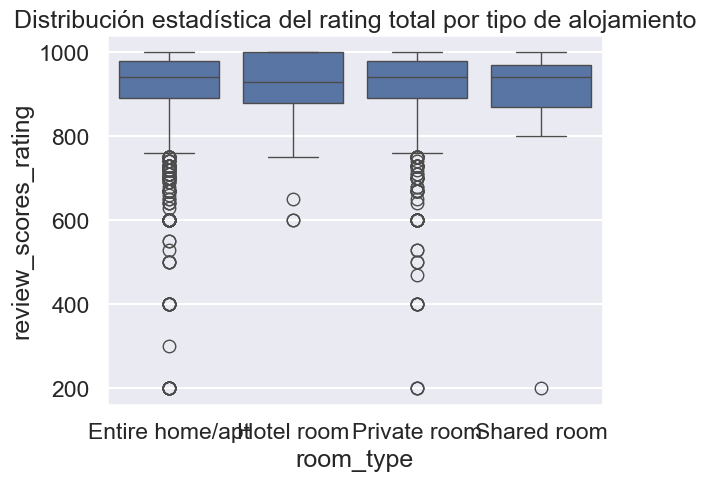

In [41]:
ax = sns.boxplot(data=df, x='room_type', y='review_scores_rating')
ax.set_title("Distribución estadística del rating total por tipo de alojamiento")

#### Frecuencia de reseñas al mes por puntuación

<Axes: xlabel='review_scores_value', ylabel='reviews_per_month'>

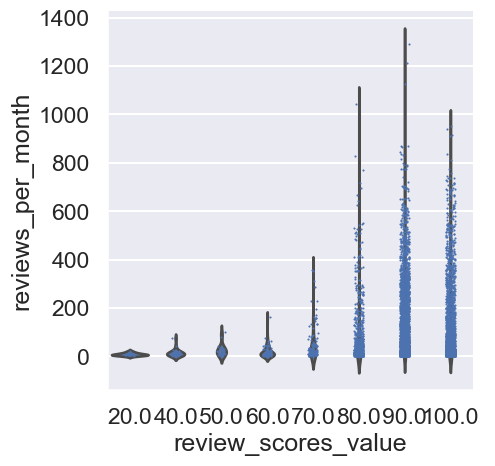

In [42]:
g = sns.catplot(data=df, x='review_scores_value', y='reviews_per_month', kind="violin", inner=None)
sns.stripplot(data=df, x='review_scores_value', y='reviews_per_month', color="b", size=1.5, ax=g.ax)

### EDA Marketing y comunicacion

#### Funciones


##### Función para añadir el símbolo € a los valores del eje

In [43]:
def euro_formatter(x, pos):
    return f"{x:,.0f}€"  # Format amb 0 

##### Función para formatear el eje y con separador de miles

In [44]:
def formato_miles(x, pos):
    return f'{int(x):,}'

##### Establecer paleta y estilo

In [45]:
sns.set_style("darkgrid")
sns.set_palette("tab10") 

#### Analisis Descriptivo

##### Variables numericas

In [46]:
print(df.describe()) 

       apartment_id       host_id  accommodates         beds        price  \
count  7.693000e+03  7.693000e+03   7693.000000  7685.000000  7693.000000   
mean   1.697283e+07  7.099342e+07      4.320551     2.970462  1023.577473   
min    1.196400e+04  1.070400e+04      1.000000     0.000000    60.000000   
25%    1.075765e+07  1.203042e+07      2.000000     1.000000   460.000000   
50%    1.808626e+07  4.880695e+07      4.000000     2.000000   750.000000   
75%    2.363590e+07  1.187918e+08      6.000000     4.000000  1250.000000   
max    3.242329e+07  3.365242e+08     29.000000    30.000000  6071.000000   
std    8.745042e+06  6.569650e+07      2.598439     2.297507   856.847084   

       minimum_nights  maximum_nights  availability_30  availability_60  \
count     7693.000000     7693.000000      7693.000000      7693.000000   
mean         4.579098      760.848174        12.356298        27.556350   
min          1.000000        1.000000         0.000000         0.000000   
25%   

##### Tipos de datos y variables nulas

In [47]:
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
Index: 7693 entries, 3656 to 3006
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 7693 non-null   int64         
 1   name                         7690 non-null   object        
 2   description                  7641 non-null   object        
 3   host_id                      7693 non-null   int64         
 4   neighbourhood_name           7693 non-null   object        
 5   neighbourhood_district       4669 non-null   object        
 6   room_type                    7693 non-null   object        
 7   accommodates                 7693 non-null   int64         
 8   bathrooms                    7656 non-null   object        
 9   bedrooms                     7657 non-null   object        
 10  beds                         7685 non-null   float64       
 11  amenities_list               7676 non-null   

#### Distribucion de precios

##### General

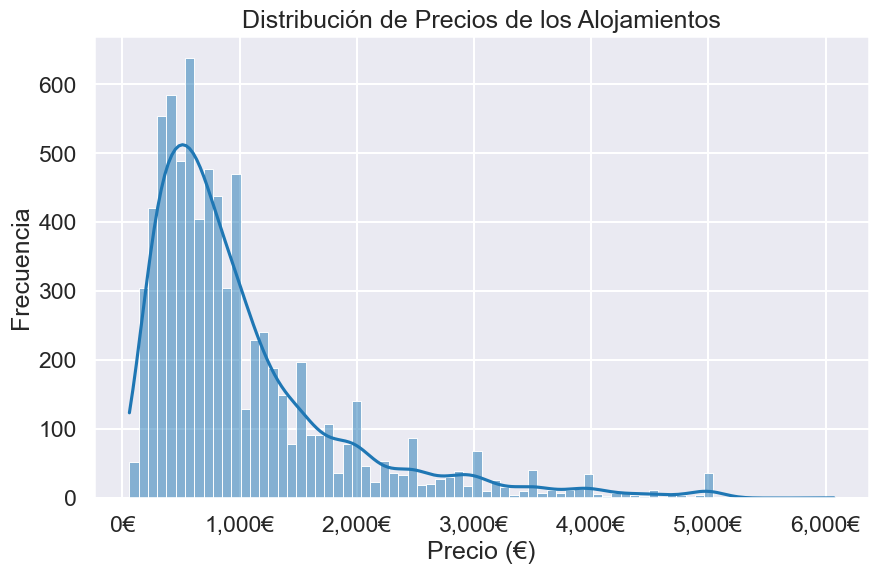

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True) #, color='blue')
plt.title('Distribución de Precios de los Alojamientos')
plt.xlabel('Precio (€)')
plt.ylabel('Frecuencia')
# Aplicar el formatter al eje X para mostrar el símbolo €
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

##### Precios por ciudad

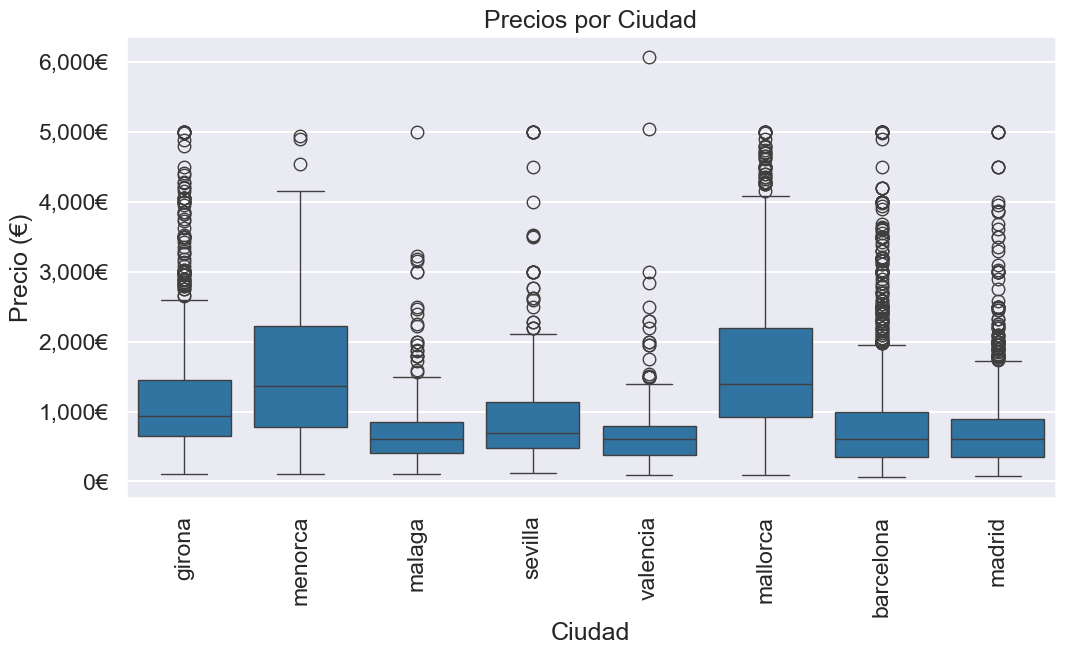

In [49]:
# Boxplot de precios por ciudad
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='price', data=df)
plt.title('Precios por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.xticks(rotation=90)
plt.show()

##### Precios por tipo de alojamiento

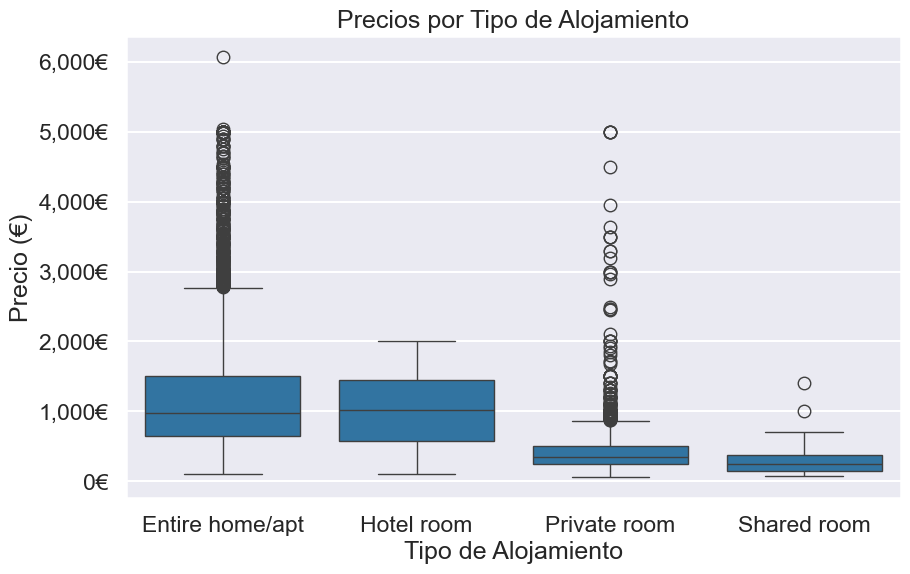

In [50]:
# Boxplot de precios por tipo de alojamiento
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Precios por Tipo de Alojamiento')
plt.xlabel('Tipo de Alojamiento')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

##### Precios por numeros de cama

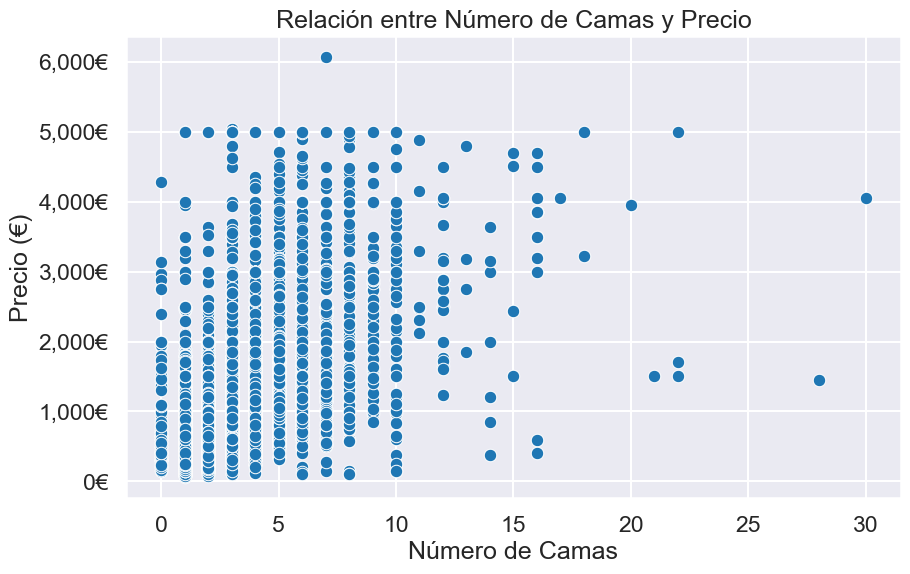

In [51]:
# Relación entre el número de camas y el precio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='beds', y='price', data=df)
plt.title('Relación entre Número de Camas y Precio')
plt.xlabel('Número de Camas')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

##### Precios por numero de habitaciones

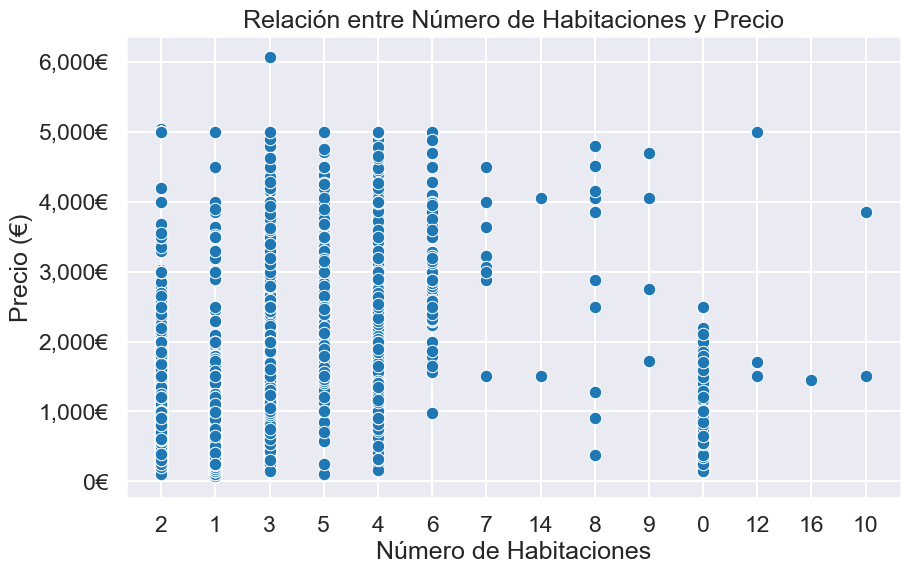

In [52]:
# Relación entre el número de habitaciones y el precio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bedrooms', y='price', data=df)
plt.title('Relación entre Número de Habitaciones y Precio')
plt.xlabel('Número de Habitaciones')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

#### Reserva instantanea y Distribucion

##### Porcentaje de alojamiento con reserva instantanea

In [53]:
instant_bookable_percentage = df['is_instant_bookable'].value_counts(normalize=True) * 100
print(instant_bookable_percentage)

is_instant_bookable
VERDADERO    55.310022
FALSO        44.689978
Name: proportion, dtype: float64


##### Distribución de alojamientos con reserva instantánea

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9848\1596701451.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_instant_bookable', data=df, palette='viridis')


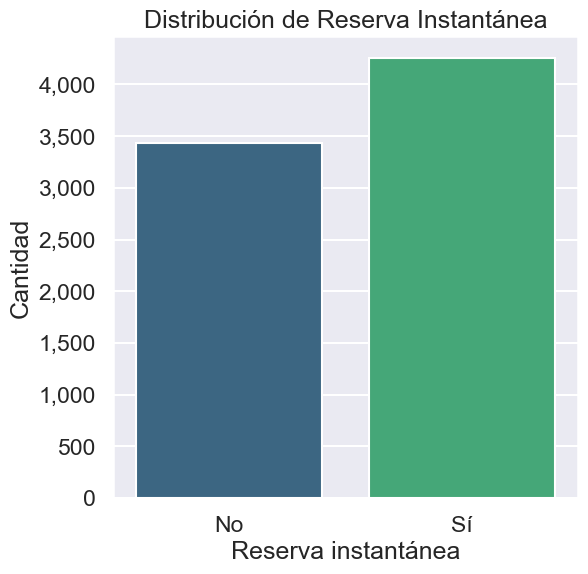

In [54]:
plt.figure(figsize=(6, 6))
sns.countplot(x='is_instant_bookable', data=df, palette='viridis')

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Reserva instantánea')
plt.ylabel('Cantidad')
plt.title('Distribución de Reserva Instantánea')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

#### Analisis de reseñas

##### Numero de reseñas y puntuaciones

Reseñas

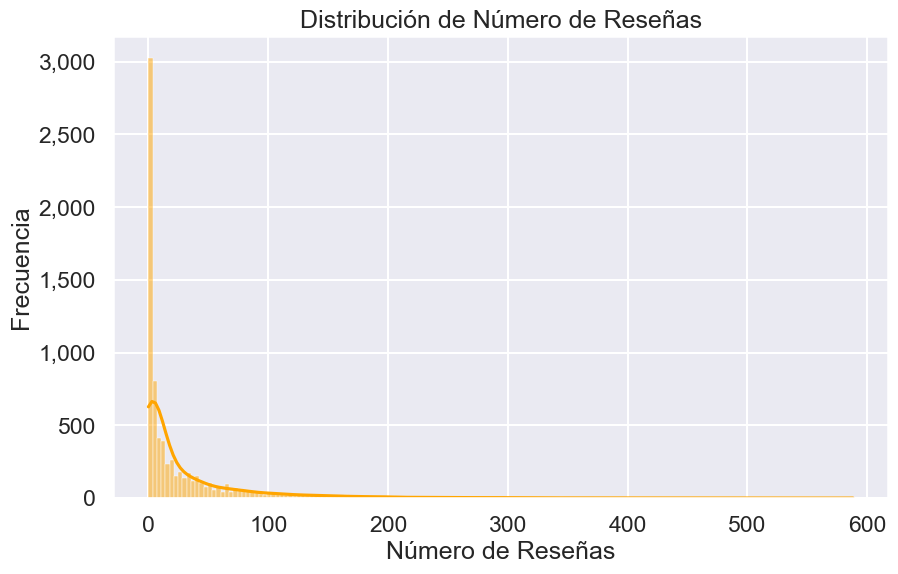

In [55]:
# Histograma de número de reseñas
plt.figure(figsize=(10, 6))
sns.histplot(df['number_of_reviews'], kde=True, color='orange')

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.title('Distribución de Número de Reseñas')
plt.xlabel('Número de Reseñas')
plt.ylabel('Frecuencia')
plt.show()

Puntuaciones

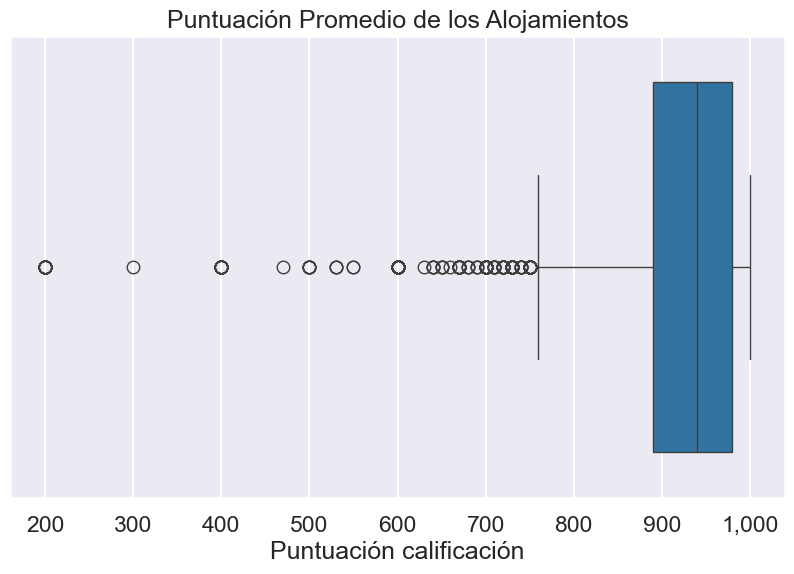

In [56]:
 # Boxplot de puntuaciones
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_scores_rating', data=df)

plt.gca().xaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Puntuación calificación')
plt.title('Puntuación Promedio de los Alojamientos')
plt.show()

##### Puntuaciones por tipo de alojamiento

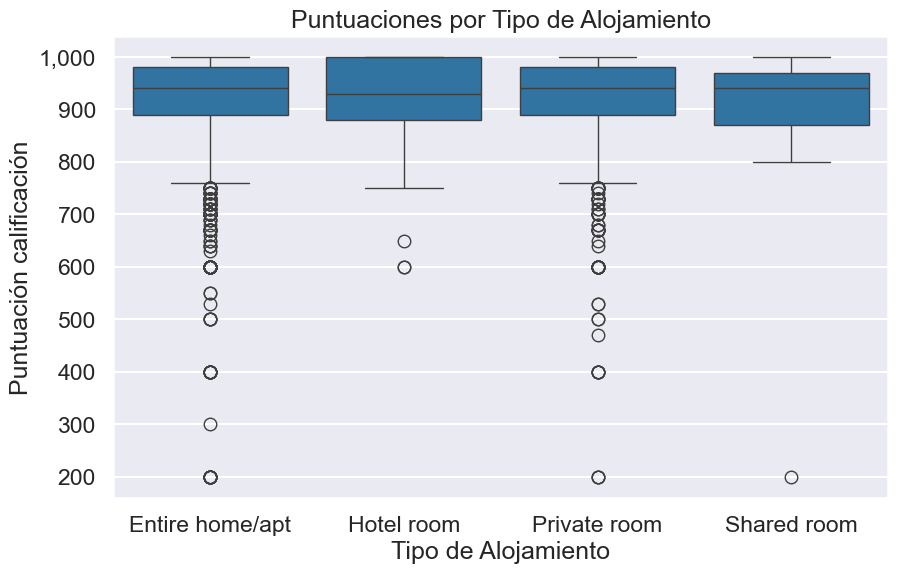

In [57]:
# Boxplot de puntuaciones por tipo de alojamiento
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='review_scores_rating', data=df)

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Tipo de Alojamiento')
plt.ylabel('Puntuación calificación')
plt.title('Puntuaciones por Tipo de Alojamiento')
plt.show()

# KPI`s

## KPI 1 - Tasa de ocupación mensual

### Tasa de ocupacion mensual general

In [58]:
# Suponiendo que 'availability_30' es el número de días disponibles en los últimos 30 días

# Calcular el número de días ocupados
df['days_occupied'] = 30 - df['availability_30']  # Si 'availability_30' tiene los días disponibles, restamos a 30

# Calcular la tasa de ocupación mensual
df['occupancy_rate'] = (df['days_occupied'] / 30) * 100  # Tasa de ocupación en porcentaje

# Mostrar las primeras filas con el KPI calculado
df[['apartment_id', 'city', 'room_type', 'availability_30', 'days_occupied', 'occupancy_rate']]

,apartment_id,city,room_type,availability_30,days_occupied,occupancy_rate
3656,17249166,girona,Entire home/apt,0,30,100.000000
5770,23040910,menorca,Entire home/apt,29,1,3.333333
7894,31968299,girona,Entire home/apt,0,30,100.000000
6749,26207763,girona,Entire home/apt,0,30,100.000000
4507,19236052,girona,Entire home/apt,0,30,100.000000
...,...,...,...,...,...,...
226,888635,barcelona,Entire home/apt,0,30,100.000000
3323,16166606,barcelona,Entire home/apt,0,30,100.000000
3188,15695052,barcelona,Private room,29,1,3.333333
2066,11198148,barcelona,Private room,20,10,33.333333


In [59]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupación promedio
kpi_occupancy = df.groupby(['city'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Mostrar el KPI por ciudad y tipo de alojamiento
print(kpi_occupancy)

        city occupancy_rate
0  barcelona         62.68%
1     girona         51.56%
2     madrid         64.09%
3     malaga         58.43%
4   mallorca         55.38%
5    menorca         51.70%
6    sevilla         52.75%
7   valencia         57.14%


### KPI 1 - Tasa de ocupación por tipo de alojamiento:
    KPI de ocupación promedio por ciudad y tipo de alojamiento.

In [60]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupación promedio
kpi_occupancy = df.groupby(['city', 'room_type'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Mostrar el KPI por ciudad y tipo de alojamiento
print(kpi_occupancy)

         city        room_type occupancy_rate
0   barcelona  Entire home/apt         63.70%
1   barcelona       Hotel room         58.89%
2   barcelona     Private room         62.22%
3   barcelona      Shared room         37.67%
4      girona  Entire home/apt         51.63%
5      girona       Hotel room         86.67%
6      girona     Private room         47.03%
7      madrid  Entire home/apt         63.30%
8      madrid       Hotel room         46.67%
9      madrid     Private room         66.51%
10     madrid      Shared room         45.00%
11     malaga  Entire home/apt         58.22%
12     malaga       Hotel room         33.33%
13     malaga     Private room         59.74%
14     malaga      Shared room         76.67%
15   mallorca  Entire home/apt         55.88%
16   mallorca       Hotel room         68.52%
17   mallorca     Private room         48.22%
18   mallorca      Shared room         57.50%
19    menorca  Entire home/apt         51.58%
20    menorca     Private room    

#### KPI 1 - Tasa de ocupación agrupada por ciudad y tipo de alojamiento en %

In [61]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupación promedio
kpi_occupancy = df.groupby(['city', 'room_type'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Mostrar el KPI por ciudad y tipo de alojamiento
print(kpi_occupancy)

         city        room_type occupancy_rate
0   barcelona  Entire home/apt         63.70%
1   barcelona       Hotel room         58.89%
2   barcelona     Private room         62.22%
3   barcelona      Shared room         37.67%
4      girona  Entire home/apt         51.63%
5      girona       Hotel room         86.67%
6      girona     Private room         47.03%
7      madrid  Entire home/apt         63.30%
8      madrid       Hotel room         46.67%
9      madrid     Private room         66.51%
10     madrid      Shared room         45.00%
11     malaga  Entire home/apt         58.22%
12     malaga       Hotel room         33.33%
13     malaga     Private room         59.74%
14     malaga      Shared room         76.67%
15   mallorca  Entire home/apt         55.88%
16   mallorca       Hotel room         68.52%
17   mallorca     Private room         48.22%
18   mallorca      Shared room         57.50%
19    menorca  Entire home/apt         51.58%
20    menorca     Private room    

#### KPI 1 - Matriz Tasa de ocupación por ciudad y tipo de alojamientos en %

In [62]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupación promedio
kpi_occupancy = df.groupby(['city', 'room_type'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Convertir el dataframe a una matriz con las ciudades como filas y los tipos de alojamiento como columnas
occupancy_matrix = kpi_occupancy.pivot_table(index='city', columns='room_type', values='occupancy_rate', aggfunc='first')

# Para reemplazar por 0 si NaN
occupancy_matrix = occupancy_matrix.fillna('0.00%')

# Convertir a formato tabla con tabulate para una mejor visualización en rejilla
occupancy_matrix_formatted = tabulate(occupancy_matrix, headers='keys', tablefmt='grid', showindex=True)

# Mostrar la tabla en formato rejilla
print(occupancy_matrix_formatted)

+-----------+-------------------+--------------+----------------+---------------+
| city      | Entire home/apt   | Hotel room   | Private room   | Shared room   |
+===========+===================+==============+================+===============+
| barcelona | 63.70%            | 58.89%       | 62.22%         | 37.67%        |
+-----------+-------------------+--------------+----------------+---------------+
| girona    | 51.63%            | 86.67%       | 47.03%         | 0.00%         |
+-----------+-------------------+--------------+----------------+---------------+
| madrid    | 63.30%            | 46.67%       | 66.51%         | 45.00%        |
+-----------+-------------------+--------------+----------------+---------------+
| malaga    | 58.22%            | 33.33%       | 59.74%         | 76.67%        |
+-----------+-------------------+--------------+----------------+---------------+
| mallorca  | 55.88%            | 68.52%       | 48.22%         | 57.50%        |
+-----------+---

## KPI 2 - Ciudad con mayor ocupación mensual

In [63]:
# La tasa de ocupación mensual ya la tenemos calculada

# Agrupar por ciudad y calcular la tasa de ocupación promedio mensual
occupancy_by_city = df.groupby('city')['occupancy_rate'].mean().reset_index()

# Encontrar la ciudad con mayor tasa de ocupación mensual
max_occupancy_city = occupancy_by_city.loc[occupancy_by_city['occupancy_rate'].idxmax()]

# Mostrar la ciudad con mayor ocupación
print(f"La ciudad con mayor ocupación mensual es {max_occupancy_city['city']} con una tasa de ocupación del {max_occupancy_city['occupancy_rate']:.2f}%")



La ciudad con mayor ocupación mensual es madrid con una tasa de ocupación del 64.09%


## KPI 3 - Índice de satisfacción general

In [64]:
Indice_satisfaccion_general = df['review_scores_value'].sum() / df['apartment_id'].count()

print(f'El índice de satisfacción general es: {Indice_satisfaccion_general:.2f}')

El índice de satisfacción general es: 71.59


## KPI 4 - Ítem con la mayor puntuación promedio

In [65]:
# Diccionario para traducir los nombres de las columnas de evaluación específicas
traducciones = {
    'review_scores_accuracy': 'Precisión',
    'review_scores_cleanliness': 'Limpieza',
    'review_scores_checkin': 'Registro',
    'review_scores_communication': 'Comunicaciones',
    'review_scores_location': 'Ubicación'
}

# Columnas originales
cols = list(traducciones.keys())

# Calcular la media de cada una (ignorando NaN)
mean_scores = df[cols].mean().rename(traducciones)

# Mostrar la métrica con mayor media
max_metric = mean_scores.idxmax()
max_value = mean_scores.max()

print(f"La métrica con la mayor puntuación promedio es: {max_metric} con un valor de {max_value:.2f}")

La métrica con la mayor puntuación promedio es: Comunicaciones con un valor de 96.34


# Preguntas de negocio

## Operaciones

### Quina és la disponibilitat mitjana dels allotjaments turístics en els diferents terminis (30, 60, 90 i 365 dies) a cada ciutat?

#### Funciones

In [66]:
def grafico_matriz_disponibilidad(disponibilidad_media, disponibilidad_media_porcentaje):
    plt.figure(figsize=(12, 8)) 
    
    matrix_combined = disponibilidad_media_porcentaje.copy()

    annotaciones = disponibilidad_media.T.apply(lambda x: x.map(lambda v: f"{round(v)} días"))
    
    sns.heatmap(matrix_combined.T, annot=annotaciones.values, fmt="", cmap='coolwarm', cbar_kws={'label': 'Disponibilidad Media (%)'}, linewidths=1)
    
    plt.title('Matriz de Disponibilidad Media por Ciudad (Porcentaje en colores, Media Normal en celdas)', fontsize=16)
    plt.xlabel('Ciudad', fontsize=12)
    plt.ylabel('Periodo de Disponibilidad', fontsize=12)
    plt.xticks(rotation=45, ha='right')  
    
    plt.tight_layout()
    plt.show()


In [67]:
def distribucion_disponibilidad_kde(df, colores):
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))

    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]

    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2
        columna = i % 2
        sns.kdeplot(disponibilidad, fill=True, color=colores[i], ax=ax[fila, columna]) 

        ax[fila, columna].set_title(f'Distribución de la Disponibilidad en los Últimos {periodo} Días', fontsize=12)
        ax[fila, columna].set_xlabel(f'Días Disponibles (Últimos {periodo} días)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    


#### Matriz de distribucion de disponibilidad

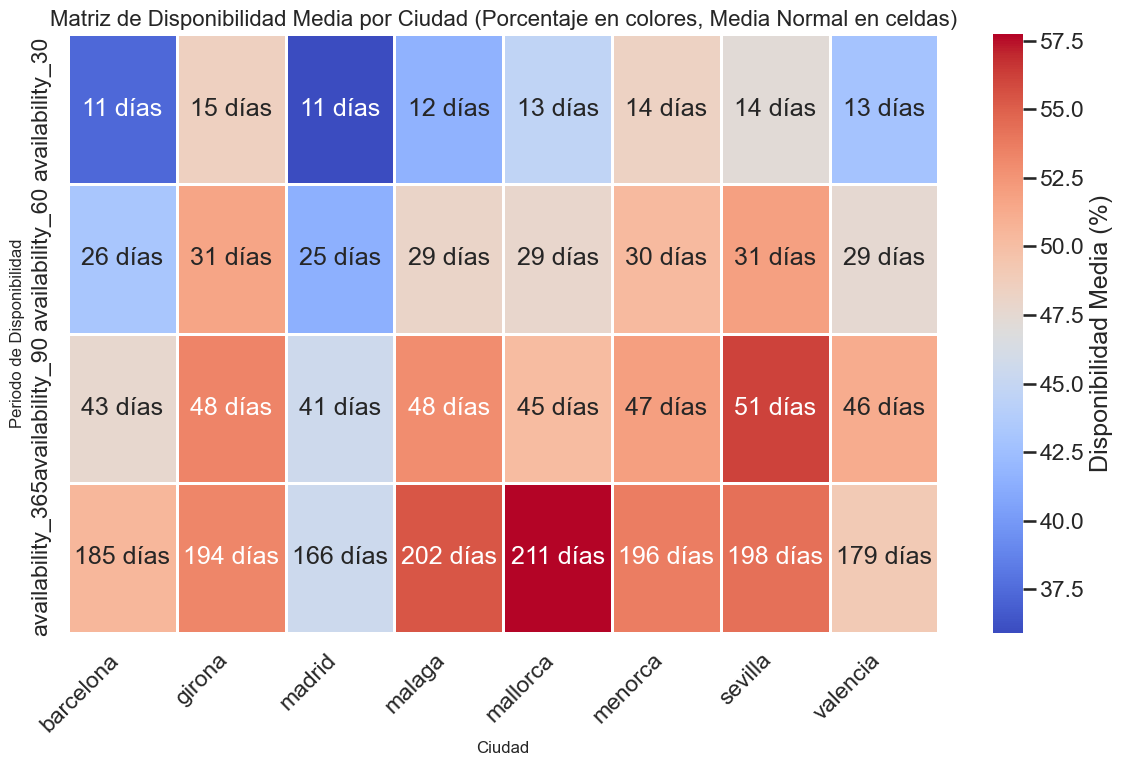

In [68]:
grafico_matriz_disponibilidad(disponibilidad_media, disponibilidad_media_porcentaje)

#### Densidad de distribucion

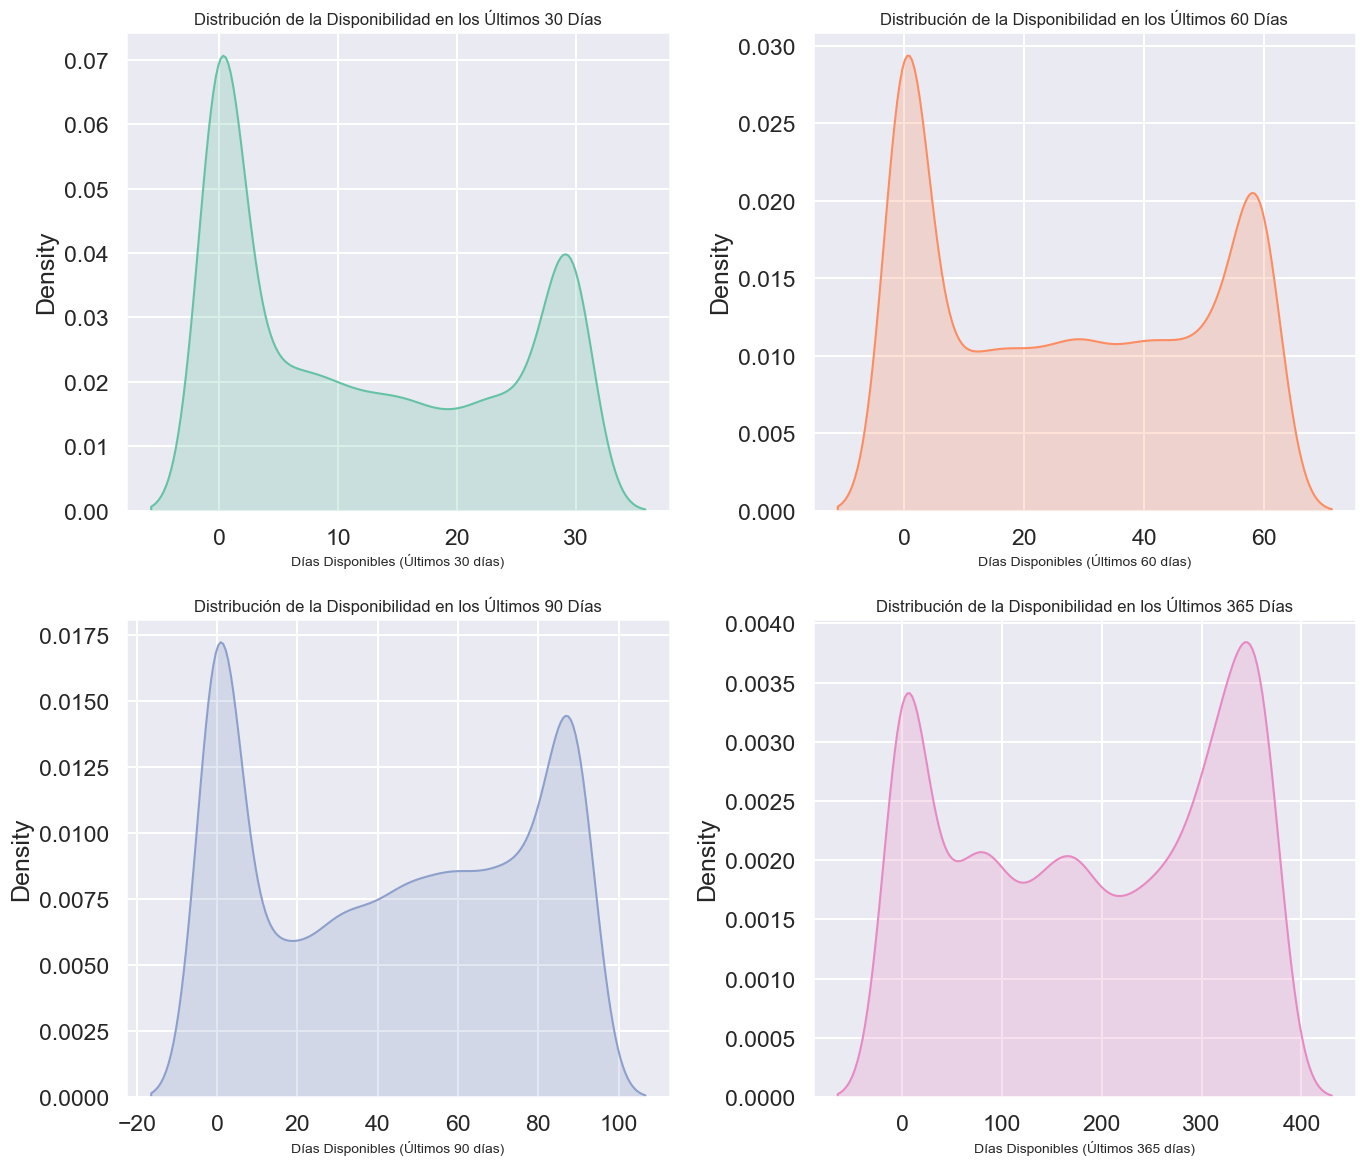

In [69]:
distribucion_disponibilidad_kde(df, colores)

In [70]:
availability_cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

# Creamos una pivot table con 'city' como índice, aplicando la función mean para cada columna
availability_matrix = df.pivot_table(
    index='city',
    values=availability_cols,
    aggfunc='mean'
)

print(availability_matrix)

           availability_30  availability_365  availability_60  availability_90
city                                                                          
barcelona        11.195931        184.592658        25.868200        42.938965
girona           14.533389        194.356427        30.998331        47.984975
madrid           10.773860        166.183587        24.848632        41.013374
malaga           12.472081        202.073604        28.824873        47.619289
mallorca         13.386561        210.735178        28.676680        45.207115
menorca          14.491018        195.970060        30.167665        46.784431
sevilla          14.173697        198.064516        31.158809        50.565757
valencia         12.858333        179.122222        28.508333        46.061111


## Marketing

### Quin és el preu mitjà dels allotjaments per tipus d'allotjament a cada ciutat?

In [71]:
# Agrupar por ciudad y tipo de alojamiento, luego calcular el precio medio
precio_medio = df.groupby(['city', 'room_type'])['price'].mean().reset_index()

# Renombrar las columnas para mayor claridad
precio_medio.columns = ['Ciudad', 'Tipo de alojamiento', 'Precio medio']

# Formatear el precio medio con 2 decimales y separador de miles
precio_medio['Precio medio'] = precio_medio['Precio medio'].apply(lambda x: f"{x:,.2f}€")

# Mostrar todas los resultados
print(precio_medio)

       Ciudad Tipo de alojamiento Precio medio
0   barcelona     Entire home/apt    1,282.82€
1   barcelona          Hotel room    1,235.83€
2   barcelona        Private room      459.12€
3   barcelona         Shared room      352.50€
4      girona     Entire home/apt    1,245.19€
5      girona          Hotel room      545.00€
6      girona        Private room      628.12€
7      madrid     Entire home/apt      953.64€
8      madrid          Hotel room      842.95€
9      madrid        Private room      373.89€
10     madrid         Shared room      290.00€
11     malaga     Entire home/apt      810.93€
12     malaga          Hotel room      703.33€
13     malaga        Private room      353.08€
14     malaga         Shared room      143.33€
15   mallorca     Entire home/apt    1,748.99€
16   mallorca          Hotel room    1,447.78€
17   mallorca        Private room      734.95€
18   mallorca         Shared room      437.50€
19    menorca     Entire home/apt    1,660.29€
20    menorca

In [72]:
# Agrupar por ciudad y tipo de alojamiento, luego calcular el precio medio
precio_medio = df.groupby(['city', 'room_type'])['price'].mean().reset_index()

# Crear la tabla pivote
tabla_pivote = precio_medio.pivot_table(index='city', columns='room_type', values='price', aggfunc='mean')

# Formatear el precio medio con 2 decimales, separador de miles y símbolo de euro
tabla_pivote = tabla_pivote.applymap(lambda x: f"{x:,.2f}€" if pd.notnull(x) else x)

# Para reemplazar por 0 si NaN
tabla_pivote = tabla_pivote.fillna('0.00€')

# Mostrar la tabla pivote resultante
print(tabla_pivote)

room_type Entire home/apt Hotel room Private room Shared room
city                                                         
barcelona       1,282.82€  1,235.83€      459.12€     352.50€
girona          1,245.19€    545.00€      628.12€       0.00€
madrid            953.64€    842.95€      373.89€     290.00€
malaga            810.93€    703.33€      353.08€     143.33€
mallorca        1,748.99€  1,447.78€      734.95€     437.50€
menorca         1,660.29€      0.00€      565.45€       0.00€
sevilla         1,044.95€    843.33€      583.27€     120.00€
valencia          786.69€    955.00€      321.79€     203.33€


C:\Users\Usuario\AppData\Local\Temp\ipykernel_9848\3302454918.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_pivote = tabla_pivote.applymap(lambda x: f"{x:,.2f}€" if pd.notnull(x) else x)


## Experiencia de clientes

### Quina és la puntuació mitjana donada pels usuaris als allotjaments turístics, i quin percentatge d'allotjaments tenen una avaluació general més gran de 80 a cada ciutat?


#### Puntuación media de los usuarios

In [73]:
media_valor = df['review_scores_value'].mean()
print(f"Puntuación media otorgada por los usuarios: {media_valor:.2f}")

Puntuación media otorgada por los usuarios: 91.40


#### Porcentaje de alojamientos por ciudad que superan una puntuación de 80

In [74]:
# Crear una columna booleana para marcar los que superan 80
df['supera_80'] = df['review_scores_value'] > 80

# Agrupar por ciudad y calcular el porcentaje
porcentaje_por_ciudad = (
    df.groupby('city')['supera_80']
    .mean().sort_values(ascending=False) * 100
).round(2)

# Convertir la Series en un DataFrame con columnas nombradas
porcentaje_por_ciudad = porcentaje_por_ciudad.reset_index()
porcentaje_por_ciudad.columns = ['city', 'supera_80']  # Renombrar columnas para claridad


print(pd.DataFrame(porcentaje_por_ciudad))

        city  supera_80
0    sevilla      83.62
1   valencia      80.83
2     malaga      77.16
3     madrid      72.52
4  barcelona      64.97
5    menorca      58.68
6   mallorca      56.52
7     girona      51.67


#### Graficos

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9848\1776001290.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=porcentaje_por_ciudad, x='supera_80', y='city', palette='viridis')


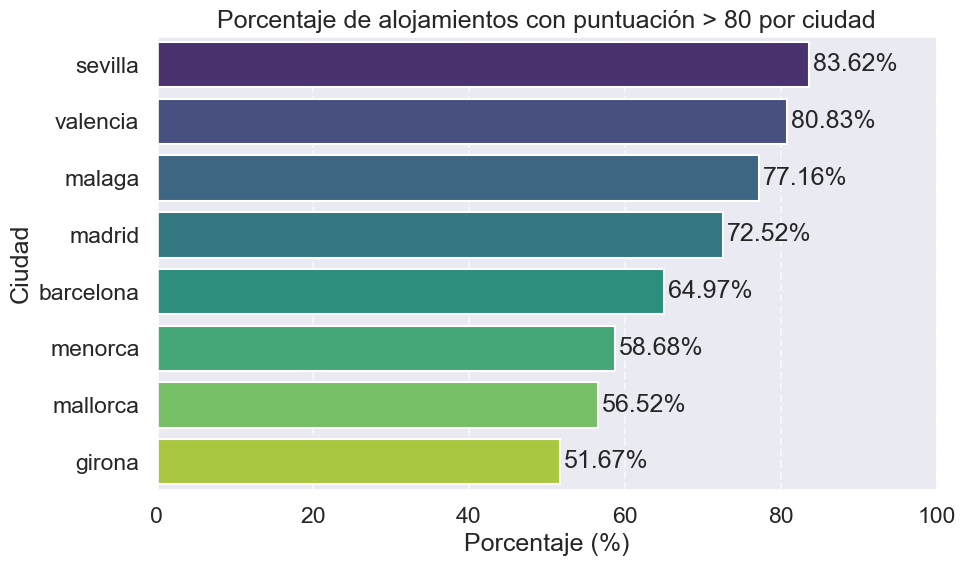

In [75]:
plt.figure(figsize=(10, 6))
sns.barplot(data=porcentaje_por_ciudad, x='supera_80', y='city', palette='viridis')

# Anotar porcentajes
for idx, row in enumerate(porcentaje_por_ciudad.itertuples()):
    plt.text(row.supera_80 + 0.5, idx, f"{row.supera_80}%", va='center')

# Ajustes visuales
plt.title('Porcentaje de alojamientos con puntuación > 80 por ciudad')
plt.xlabel('Porcentaje (%)')
plt.ylabel('Ciudad')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# CSV

In [76]:
#df.to_csv("../data/2025_04_22_Sprint02.csv", index=False)

PRUEBAS DE PREGUNTA 2 DE OPERACIONES

In [77]:
df1 = df.groupby(['city', 'is_instant_bookable'])[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean().reset_index()


In [78]:
pivot_df = df1.pivot(index='city', columns='is_instant_bookable', values=['availability_30', 'availability_60', 'availability_90', 'availability_365'])


In [79]:
pivot_df

availability_30            availability_60             \
is_instant_bookable           FALSO  VERDADERO           FALSO  VERDADERO   
city                                                                        
barcelona                 11.341887  11.028490       25.712748  26.046534   
girona                    16.706366  13.045007       35.400411  27.983122   
madrid                    10.631868  10.886587       23.550824  25.878953   
malaga                    12.553719  12.435897       28.719008  28.871795   
mallorca                  13.303327  13.442971       28.729941  28.640584   
menorca                   15.576923  13.539326       31.807692  28.730337   
sevilla                   13.359375  14.552727       29.757812  31.810909   
valencia                  13.581921  12.158470       29.830508  27.229508   

                    availability_90            availability_365              
is_instant_bookable           FALSO  VERDADERO            FALSO   VERDADERO  
city                                                                         
barcelona                 42.216887  43.767331       178.085265  192.057930  
girona                    54.993840  43.184248       233.301848  167.680731  
madrid                    38.342033  43.134133       157.868132  172.785169  
malaga                    47.818182  47.531136       197.917355  203.915751  
mallorca                  45.682975  44.884615       214.861057  207.938992  
menorca                   48.679487  45.123596       213.564103  180.550562  
sevilla                   48.601562  51.480000       191.656250  201.047273  
valencia                  47.355932  44.808743       184.966102  173.469945

In [80]:
pivot_df['Coeficiente (30 días)'] = (pivot_df[('availability_30', 'VERDADERO')] - pivot_df[('availability_30', 'FALSO')]) / (pivot_df[('availability_30', 'VERDADERO')] + pivot_df[('availability_30', 'FALSO')])
pivot_df['Coeficiente (60 días)'] = (pivot_df[('availability_60', 'VERDADERO')] - pivot_df[('availability_60', 'FALSO')]) / (pivot_df[('availability_60', 'VERDADERO')] + pivot_df[('availability_60', 'FALSO')])
pivot_df['Coeficiente (90 días)'] = (pivot_df[('availability_90', 'VERDADERO')] - pivot_df[('availability_90', 'FALSO')]) / (pivot_df[('availability_90', 'VERDADERO')] + pivot_df[('availability_90', 'FALSO')])
pivot_df['Coeficiente (365 días)'] = (pivot_df[('availability_365', 'VERDADERO')] - pivot_df[('availability_365', 'FALSO')]) / (pivot_df[('availability_365', 'VERDADERO')] + pivot_df[('availability_365', 'FALSO')])

In [81]:
pivot_df[["Coeficiente (30 días)","Coeficiente (60 días)","Coeficiente (90 días)","Coeficiente (365 días)"]]

,Coeficiente (30 días),Coeficiente (60 días),Coeficiente (90 días),Coeficiente (365 días)
is_instant_bookable,,,,
city,,,,
barcelona,-0.014009,0.006449,0.018032,0.037749
girona,-0.123065,-0.117022,-0.120287,-0.163651
madrid,0.011837,0.047100,0.058816,0.045114
malaga,-0.004715,0.002653,-0.003010,0.014928
mallorca,0.005221,-0.001558,-0.008815,-0.016372
menorca,-0.069981,-0.050833,-0.037908,-0.083766
sevilla,0.042754,0.033346,0.028761,0.023914
valencia,-0.055300,-0.045584,-0.027637,-0.032073


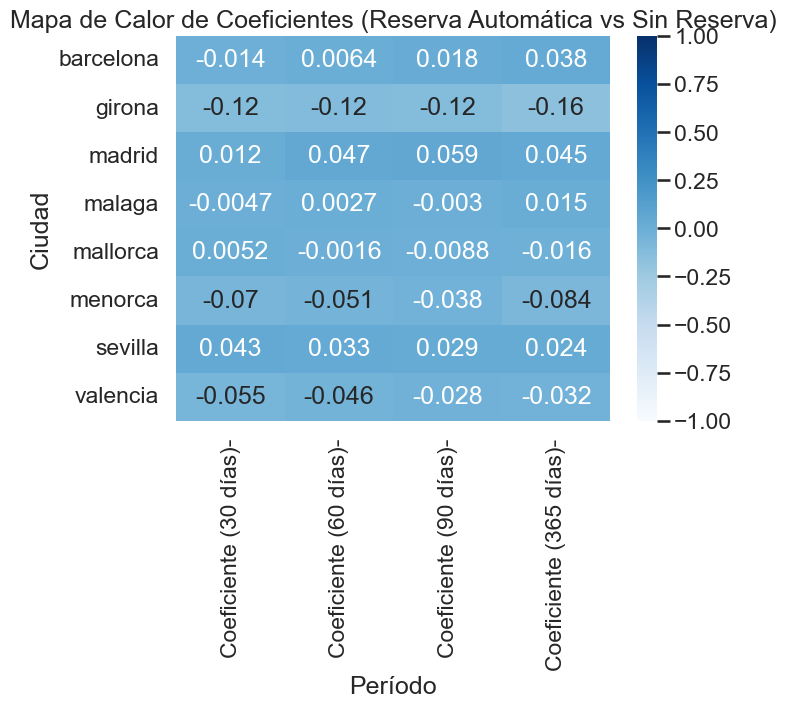

In [82]:
coeficientes = pivot_df[['Coeficiente (30 días)', 'Coeficiente (60 días)', 'Coeficiente (90 días)', 'Coeficiente (365 días)']]

# Crear el mapa de calor
plt.figure(figsize=(7, 5))  # Tamaño del gráfico
ax = sns.heatmap(coeficientes, annot=True, cmap="Blues", xticklabels=True, yticklabels=pivot_df.index, vmin=-1, vmax=1)

# Títulos y etiquetas
plt.title('Mapa de Calor de Coeficientes (Reserva Automática vs Sin Reserva)')
plt.xlabel('Período')
plt.ylabel('Ciudad')

# Mostrar el gráfico
plt.show()

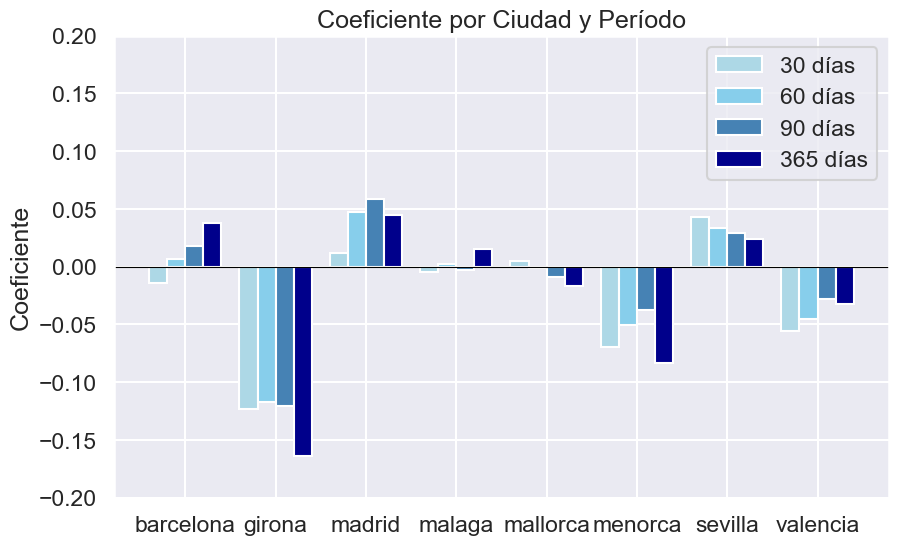

In [83]:
ind = np.arange(len(pivot_df))  # posiciones para cada ciudad
width = 0.2  # anchura de cada barra

# Extraer los coeficientes para cada período
coef30 = pivot_df['Coeficiente (30 días)']
coef60 = pivot_df['Coeficiente (60 días)']
coef90 = pivot_df['Coeficiente (90 días)']
coef365 = pivot_df['Coeficiente (365 días)']

fig, ax = plt.subplots(figsize=(10, 6))

# Usar tonos de azul específicos para cada grupo de barras
ax.bar(ind - 1.5 * width, coef30, width, color='#ADD8E6', label='30 días')  # Azul claro
ax.bar(ind - 0.5 * width, coef60, width, color='#87CEEB', label='60 días')  # Azul cielo
ax.bar(ind + 0.5 * width, coef90, width, color='#4682B4', label='90 días')  # Azul acero
ax.bar(ind + 1.5 * width, coef365, width, color='#00008B', label='365 días')  # Azul oscuro

ax.set_ylim(-0.2, 0.2) #Cambiar el eje segun necesidad
ax.set_xticks(ind)
ax.set_xticklabels(pivot_df.index)
ax.axhline(0, color='black', linewidth=0.8)  # línea de referencia en 0
ax.set_ylabel('Coeficiente')
ax.set_title('Coeficiente por Ciudad y Período')
ax.legend()
plt.show()

In [84]:
# Agrupar los datos por ciudad y calcular cuántos pisos tienen reservas automáticas y cuántos no
tabla_resumen = df.groupby(['city', 'is_instant_bookable']).size().unstack(fill_value=0)

# Renombrar las columnas para mayor claridad
tabla_resumen.columns = ['Sin Reserva Automática', 'Con Reserva Automática']

print(tabla_resumen)

           Sin Reserva Automática  Con Reserva Automática
city                                                     
barcelona                    1208                    1053
girona                        487                     711
madrid                        728                     917
malaga                        121                     273
mallorca                      511                     754
menorca                        78                      89
sevilla                       128                     275
valencia                      177                     183


Pruebas tablas presentacion

In [85]:
coeficientes = pivot_df[["Coeficiente (30 días)", "Coeficiente (60 días)", "Coeficiente (90 días)", "Coeficiente (365 días)"]]

# Función para aplicar colores condicionales por celda
def fondo_personalizado(val):
    if val > 0:
        return 'background-color: #cce5ff'  # Azul claro
    else:
        return 'background-color: #f9f9f9'  # Casi blanco

# Aplicar estilo personalizado
def estilo_coeficientes_condicional(tabla):
    return tabla.style.applymap(fondo_personalizado).set_properties(**{
        'color': 'black',
        'text-align': 'center'
    }).set_table_styles([
        {
            'selector': 'th',
            'props': [('background-color', 'white'),
                      ('color', 'black'),
                      ('font-weight', 'bold'),
                      ('text-align', 'center')]
        },
        {
            'selector': 'td',
            'props': [('font-weight', 'normal')]
        }
    ]).set_caption("Coeficientes de disponibilidad media por ciudad")

# Mostrar la tabla estilizada
estilo_coeficientes_condicional(coeficientes)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9848\4082547675.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  return tabla.style.applymap(fondo_personalizado).set_properties(**{


,Coeficiente (30 días),Coeficiente (60 días),Coeficiente (90 días),Coeficiente (365 días)
is_instant_bookable,,,,
city,,,,
barcelona,-0.014009,0.006449,0.018032,0.037749
girona,-0.123065,-0.117022,-0.120287,-0.163651
madrid,0.011837,0.047100,0.058816,0.045114
malaga,-0.004715,0.002653,-0.003010,0.014928
mallorca,0.005221,-0.001558,-0.008815,-0.016372
menorca,-0.069981,-0.050833,-0.037908,-0.083766
sevilla,0.042754,0.033346,0.028761,0.023914
valencia,-0.055300,-0.045584,-0.027637,-0.032073


In [86]:
tabla_resumen.columns = ['Número de Alojamientos<br>Sin Reserva Automática', 'Número de Alojamientos<br>Con Reserva Automática']

def estilo_tabla_azul_claro_centrada(tabla):
    styled = tabla.style.background_gradient(
        cmap='Blues',
        axis=None,
        low=0.1, high=0.4
    ).set_properties(**{
        'color': 'black',
        'text-align': 'center'  # Centramos el texto
    }).set_table_styles([
        {
            'selector': 'th',
            'props': [('background-color', 'white'),
                      ('color', 'black'),
                      ('font-weight', 'bold'),
                      ('text-align', 'center')]  # Centramos también el encabezado
        },
        {
            'selector': 'td',
            'props': [('font-weight', 'normal')]
        }
    ]).set_caption("Resumen de alojamientos por ciudad")
    
    return styled

# Mostrar la tabla con estilo centrado
estilo_tabla_azul_claro_centrada(tabla_resumen)


,Número de AlojamientosSin Reserva Automática,Número de AlojamientosCon Reserva Automática
city,,
barcelona,1208,1053
girona,487,711
madrid,728,917
malaga,121,273
mallorca,511,754
menorca,78,89
sevilla,128,275
valencia,177,183
